In [1]:
from common import *

import xml.etree.ElementTree as ET
from pymongo import MongoClient
import pymongo
from matplotlib import pyplot as plt

from pymystem3 import Mystem
from bson.objectid import ObjectId
import re
from bson.son import SON
import gridfs
from pprint import pprint

from matplotlib import pyplot as plt

In [2]:
fname = join(join(DATA_FOLDER, 'rawdata'), 'all_docs_raw.txt')

In [3]:
# all_docs = glob(join(DATA_FOLDER, 'rawdata') + '/**/*.xml', recursive=True)
# all_docs = sorted(all_docs)
# with open(fname, mode='wt', encoding='utf-8') as f:
#     f.write('\n'.join(all_docs))

In [76]:
with open(fname, mode='r', encoding='utf-8') as f:
    all_docs = f.read().splitlines()

In [ ]:
len(all_docs)

In [ ]:
def get_node(root, name, lang='ru'):
    for node in root.iter(name):
        if 'lang' in node.attrib:
            if node.attrib['lang'].lower() == lang:
                return node
        else:
            return node

In [ ]:
def parse_xml(fname, mstem, lemmatize=True, save_raw=True):
    doc = {}

    with open(fname, 'r', encoding='utf8') as f:
        text = f.read()
        text = text.replace('&deg', 'deg')
    
    try:
        root = ET.fromstring(text)
    except:
        print(fname)
        return
    
    doc.update(root.attrib)

    raw_texts = {}
    
    SDOBI = get_node(root, 'SDOBI')
    if SDOBI is not None:
        node = SDOBI.find('./B500/ru-b540/ru-b542')
        if node is not None:
            raw_texts['name'] = node.text.lower()
        else:
            print(fname)            
    else:
        print('no SDOBI: ' + fn)

    node = get_node(root, 'abstract')
    if node is not None:
        raw_texts['abstract'] = ' '.join(node.itertext()).lower()

    if SDOBI is not None:
        node = SDOBI.find('./B500/B560/ru-b560')
        if node is not None:
            doc['ru-b560'] = ' '.join(node.itertext())

    node = get_node(root, 'description')
    if node is not None:
        raw_texts['description'] = ' '.join(node.itertext()).lower()

    node = get_node(root, 'claims')
    if node is not None:
        raw_texts['claims'] = ' '.join(node.itertext()).lower()        
    
    
    for k,v in raw_texts.items():
        if save_raw:
            doc[k + '_raw'] = v
        if lemmatize:
            doc[k] = ''.join(mstem.lemmatize(v))    
    
    return doc

# Test

In [7]:
afile = '../data/rawdata/2016/RU/A/20161227/2015116494/2015116494.xml'
c1file = '../data/rawdata/2016/RU/C1/20161227/0002605713/0002605713.xml'
c2file = '../data/rawdata/2016/RU/C2/20160127/0002573901/0002573901.xml'
ufile = '../data/rawdata/2016/RU/U1/20161210/0000166582/0000166582.xml'

In [8]:
mstem = Mystem()
doc = parse_xml(c2file, mstem)

Installing mystem to /home/administrator/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [21]:
print(doc['description'])

область техника настоящий изобретение относиться к способ получение поверхностный покрытие на основа поливинилхлорид (пвх), содержать слой износ на основа пвх и слой на основа поливиниловый спирт. предшествующий уровень техника поверхностный покрытие на основа пвх широко применять для декорирование сооружение, дом или транспортный средство. однако поверхностный покрытие на основа пвх обладать недостаток высвобождение летучий органический соединение (лос), некоторый из который токсичный. для уменьшение или предотвращение высвобождение лос быть предлагать замещать летучий соединение нелетучий соединение. однако этот приводить к значительный снижение жесткость поверхностный покрытие, в тот время как жесткость являться важный требование для упругий поверхностный покрытие, особенно напольный покрытие. также быть предлагать применение полиэфирный или полиамидный слой в качество защитный слой или в качество промежуточный слой в многослойный поверхностный покрытие. поливинилспиртовой (пвс) сло

In [9]:
doc

{'abstract': 'изобретение относиться к способ получение поверхностный покрытие, содержать этап обеспечение слой износ на основа пвх (1), по существо, свободный от неорганический наполнитель, нанесение на упоминать слой на основа пвх (1) композиция верхний покрытие, содержать поливиниловый спирт (пвс) и соединение силан, содержать по меньший мера один аминогруппа, нагревание упоминать слой на основа пвх (1) и упоминать композиция верхний покрытие при температура, эквивалентный или превосходить 150°c, для образование верхний покрытие слой износ (2). результат являться получение поверхностный покрытие, сочетать свойство физический устойчивость и свойство химический и газовый барьер. 2 н. и 12 з.п. ф-лы, 4 ил., 6 табла.\n',
 'abstract_raw': 'изобретение относится к способу получения поверхностного покрытия, содержащему этапы обеспечения слоя износа на основе пвх (1), по существу, свободного от неорганических наполнителей, нанесения на упомянутый слой на основе пвх (1) композиции верхнего п

# Fill database with data

In [4]:
client = MongoClient()
db = client.fips

In [6]:
# result = db.patents.create_index([('doc-number', pymongo.ASCENDING),
#                                    ('kind', pymongo.ASCENDING),
#                                    ('country', pymongo.ASCENDING),
#                                    ('date-publ', pymongo.ASCENDING)], unique=True)
# sorted(list(db.patents.index_information()))

In [6]:
def save_to_mongodb(doc_list):
    client = MongoClient()
    db = client.fips
    patents = db.patents
    
    mstem = Mystem()
    
    for fn in doc_list:
        doc = parse_xml(fn, mstem, True, True)
        if doc is not None:
            patents.insert_one(doc)

In [12]:
len(all_docs)//(cpu_count*100)

395

In [ ]:
split_on = len(all_docs)//(cpu_count*100)

for i,sub_docs in enumerate(tqdm(np.array_split(all_docs, split_on))):
    ! rm -f ../data/out
    ! echo {i} >> ../data/out
    
    parallelizer = Parallel(n_jobs=cpu_count)

    # this iterator returns the functions to execute for each task
    tasks_iterator = ( delayed(save_to_mongodb)(list_block) for 
                      list_block in grouper(100, sub_docs) ) 
    result = parallelizer( tasks_iterator )

 21%|██▏       | 84/395 [23:52<54:56, 10.60s/it]  

../data/rawdata/1999/RU/C1/19990220/0002126409/0002126409.xml


 93%|█████████▎| 369/395 [2:40:03<29:43, 68.61s/it]t]

../data/rawdata/2015/Patents/xrfd201503/DOC/RUNWC2/000/000/002/560/425/document.xml


100%|██████████| 395/395 [2:58:26<00:00, 44.67s/it]


In [16]:
# docs = []
# mstem = Mystem()

# for fn in tqdm(all_docs):
#     doc = parse_xml(fn, mstem, False, False)
#     if doc is not None:
#         patents.insert_one(doc)
# #         docs.append(doc)

In [ ]:
# patents.insert_many(docs)

# Analyze data

In [4]:
client = MongoClient()
db = client.fips

In [7]:
pipeline = [
     {"$group": {"_id": "$kind", "count": {"$sum": 1}}},
     {"$sort": SON([("count", -1), ("_id", -1)])}
 ]

pprint.pprint(list(db.patents.aggregate(pipeline)))

[{'_id': 'A ', 'count': 438164},
 {'_id': 'C1', 'count': 380857},
 {'_id': 'C2', 'count': 214003},
 {'_id': 'U1', 'count': 167301},
 {'_id': 'A1', 'count': 60184},
 {'_id': 'C ', 'count': 2527},
 {'_id': 'C9', 'count': 1372},
 {'_id': 'A2', 'count': 1028},
 {'_id': 'A3', 'count': 824},
 {'_id': 'U8', 'count': 650},
 {'_id': 'C8', 'count': 13},
 {'_id': 'A4', 'count': 13},
 {'_id': 'A8', 'count': 4}]


In [9]:
db.patents.find({ 'ru-b560': {'$exists': True}}).count()

591782

In [13]:
pipeline = [
    {"$match":{"ru-b560":{'$exists': True}}},
    {"$group": {"_id": "$kind", "count": {"$sum": 1}}},
    {"$sort": SON([("count", -1), ("_id", -1)])}
 ]

pprint.pprint(list(db.patents.aggregate(pipeline)))

[{'_id': 'C1', 'count': 363083},
 {'_id': 'C2', 'count': 213916},
 {'_id': 'A1', 'count': 10647},
 {'_id': 'C ', 'count': 2042},
 {'_id': 'C9', 'count': 1365},
 {'_id': 'A3', 'count': 398},
 {'_id': 'A2', 'count': 305},
 {'_id': 'C8', 'count': 12},
 {'_id': 'A4', 'count': 9},
 {'_id': 'U8', 'count': 4},
 {'_id': 'U1', 'count': 1}]


In [54]:
topn = db.patents.find({'kind': 'C1', 'ru-b560': {'$exists': True}}, 
                       {'ru-b560': 1, "_id": 0}).skip(24300).limit(100)
pprint(list(topn))

[{'ru-b560': 'Патент GB N 2024829, C 07G 7/00, \n\n1980.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1404050, A 23 K 1/00, 1988 г.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1284240, кл. C 21C 7/10,\n'
             '\n'
             ' 1985.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1809185, кл. F 15B 15/22, '
             '1990.Авторское свидетельство СССР N 697763, кл. F 16F 9/48, '
             '1979.'},
 {'ru-b560': 'Преображенский В.И. Полупроводниковые выпрямители. М.: '
             'Энергоатомиздат, 1986, с.41-42.Авторское свидетельство СССР \n'
             '\n'
             'N 1684894, кл. H 02P 1/28, 1989.'},
 {'ru-b560': '1. Авторское свидетельство СССР N 415130, кл. B 23P 19/02, '
             '1974.2. Авторское свидетельство СССР N 1234152, кл. B 23P '
             '19/02,\n'
             ' 1986.'},
 {'ru-b560': 'Патент США N 4795248, кл. G 02C 7/04, 1989.'},
 {'ru-b560': 'ГОСТ 4347-77, с.2.'},
 {'ru-b560': 'Авторское свидетельство СССР N 286159, кл. C 03B 3

In [157]:
p = re.compile('(?i:ru|su)(?:\s*\d+\s*){5,}(?:A(?:1|2|3|4|8|)|C(?:1|2|8|9|)|U(?:1|8))*')

topn = db.patents.find({'ru-b560': {'$exists': True}}, 
                       {'ru-b560': 1})

regexed = {}
for doc in topn:
    found = p.findall(doc['ru-b560'])
    if len(found):
        regexed[str(doc['_id'])] = found
#         if doc['kind'] == 'C1':
#             print(doc['ru-b560'])

In [158]:
len(regexed)
# {'A1': 9, 'C1': 248427, 'C2': 194130, 'C8': 12, 'C9': 1211, 'U8': 4}

443793

In [159]:
sum([len(s) for s in regexed])

10651032

In [92]:
diff = list(set(regexed2.keys()).symmetric_difference(regexed.keys()))

In [93]:
len(diff)

110973

In [321]:
# for el in diff:
#     print(regexed2[el])

In [417]:
top10 = db.patents.find({'doc-number': {'$regex': '^[0]{0,}2077319$' }}).skip(0).limit(10)
pprint(list(top10))
print(top10.count())

[{'_id': ObjectId('5984b8c2b6b11338436384fc'),
  'abstract': 'способ лечение псориаз относиться к медицина, конкретно к '
              'дерматология. \n'
              'сущность способ заключаться в \n'
              'пероральный введение биологически активный вещество и нанесение '
              'на очаг поражение, на фон диета и нормализация режим труд и '
              'отдых, первый лечебный мазь, содержать \n'
              'свежий яичный белок, пчелиный мед,\n'
              ' крем детский, солидол. затем после исчезновение бляшка '
              'наносить второй лечебный мазь, содержать свежий яичный белок, '
              'крем детский, порошок трава чистотел. новизна \n'
              'способ состоять в то, что в \n'
              'качество биологически активный вещество вводить настойка '
              'заманиха, или элеутерококк, или золотой корень, или левзея, или '
              'аралия маньчжурский в количество 30 - 40 капля 3 \n'
              'раз в день за 30 минута д

1


# In memory search

In [8]:
topn = db.patents.find({}, {'doc-number': 1, 'country': 1, 'kind': 1})

docs = {}
for doc in topn:
    _id = str(doc['_id'])
    del doc['_id']
    doc['country'] = doc['country'].upper()
    doc['kind'] = doc['kind'].upper()
    doc['doc-number'] = doc['doc-number'].zfill(10)
    docs[_id] = doc

In [9]:
len(docs)

1266940

In [10]:
pprint(list(islice(docs.items(), 100)))

[('5984b578b6b11303c16384ee',
  {'country': 'RU', 'doc-number': '0002000715', 'kind': 'C1'}),
 ('5984b578b6b11303ca6384ee',
  {'country': 'RU', 'doc-number': '0002001615', 'kind': 'C1'}),
 ('5984b578b6b11303b26384ee',
  {'country': 'RU', 'doc-number': '0001630505', 'kind': 'C '}),
 ('5984b578b6b11303bf6384ee',
  {'country': 'RU', 'doc-number': '0002000515', 'kind': 'C1'}),
 ('5984b578b6b11303b36384ee',
  {'country': 'RU', 'doc-number': '0001376447', 'kind': 'C '}),
 ('5984b578b6b11303b66384ee',
  {'country': 'RU', 'doc-number': '0001766156', 'kind': 'C '}),
 ('5984b578b6b11303c16384ef',
  {'country': 'RU', 'doc-number': '0002000716', 'kind': 'C1'}),
 ('5984b578b6b11303b86384ee',
  {'country': 'RU', 'doc-number': '0001609340', 'kind': 'C '}),
 ('5984b578b6b11303bd6384ee',
  {'country': 'RU', 'doc-number': '0002000314', 'kind': 'C1'}),
 ('5984b578b6b11303cf6384ee',
  {'country': 'RU', 'doc-number': '0002002115', 'kind': 'C1'}),
 ('5984b578b6b11303b06384ee',
  {'country': 'RU', 'doc-numbe

In [11]:
tuples = [(v['country'], v['doc-number'], v['kind']) for k,v in docs.items()]
index = pd.MultiIndex.from_tuples(tuples, names=['country', 'doc-number', 'kind'])

In [12]:
docs_df = pd.DataFrame([k for k,v in docs.items()], index = index, columns=['_id'])
docs_df.sort_index(inplace=True)

In [13]:
docs_df

_id
country doc-number kind                          
RU      0000000001 U1    5984b623b6b1130b7e63850f
        0000000002 U1    5984b623b6b1130b7e638510
        0000000003 U1    5984b623b6b1130b7e638511
        0000000004 U1    5984b623b6b1130b7e638512
        0000000005 U1    5984b624b6b1130b7e638513
        0000000006 U1    5984b624b6b1130b7e638514
        0000000007 U1    5984b624b6b1130b7e638515
        0000000008 U1    5984b624b6b1130b7e638516
        0000000009 U1    5984b624b6b1130b7e638517
        0000000010 U1    5984b624b6b1130b7e638518
        0000000011 U1    5984b624b6b1130b7e638519
        0000000012 U1    5984b624b6b1130b7e63851a
        0000000013 U1    5984b624b6b1130b7e63851b
        0000000014 U1    5984b624b6b1130b7e63851c
        0000000015 U1    5984b624b6b1130b7e63851d
        0000000016 U1    5984b625b6b1130b7e63851e
        0000000017 U1    5984b625b6b1130b7e63851f
        0000000018 U1    5984b625b6b1130b7e638520
        0000000019 U1    5984b625b6b1130b7e638521
        0000000020 U1    5984b625b6b1130b7e638522
        0000000021 U1    5984b625b6b1130b7e638523
        0000000022 U1    5984b625b6b1130b7e638524
        0000000023 U1    5984b625b6b1130b7e638525
        0000000024 U1    5984b625b6b1130b7e638526
        0000000025 U1    5984b625b6b1130b7e638527
        0000000026 U1    5984b625b6b1130b7e638528
        0000000027 U1    5984b625b6b1130b7e638529
        0000000028 U1    5984b625b6b1130b7e63852a
        0000000029 U1    5984b625b6b1130b7e63852b
        0000000030 U1    5984b625b6b1130b7e63852c
...                                           ...
SU      0001841241 A1    5984df40b6b1133fa963852f
        0001841242 A1    5984df40b6b1133fa9638530
        0001841243 A1    5984df40b6b1133fa9638531
        0001841244 A1    5984df40b6b1133fa9638532
        0001841245 A1    5984df41b6b1133fa9638533
        0001841246 A1    5984df41b6b1133fa9638534
        0001841247 A1    5984df41b6b1133fa9638535
        0001841248 A1    5984df41b6b1133fa9638536
        0001841249 A1    5984df41b6b1133fa9638537
        0001841250 A1    5984df41b6b1133fa9638538
        0001841251 A1    5984df41b6b1133fa9638539
        0001841252 A1    5984df41b6b1133fa963853a
        0001841253 A1    5984df41b6b1133fa963853b
        0001841254 A1    5984df41b6b1133fa963853c
        0001841255 A1    5984df41b6b1133fa963853d
        0001841256 A1    5984df42b6b1133fa963853e
        0001841257 A1    5984df42b6b1133fa963853f
        0001841258 A1    5984df42b6b1133fa9638540
        0001841259 A1    5984df42b6b1133fa9638541
        0001841260 A1    5984df42b6b1133fa9638542
        0001841261 A1    5984df42b6b1133fa9638543
        0001841262 A1    5984df42b6b1133fa9638544
        0001841263 A1    5984df42b6b1133fa9638545
        0001841264 A2    5984df3db6b1133fa6638558
        0001841265 A1    5984df42b6b1133fa9638546
        0001841266 A1    5984df42b6b1133fa9638547
        0001841267 A1    5984df42b6b1133fa9638548
        0001841268 A1    5984df42b6b1133fa9638549
        0001841269 A1    5984df42b6b1133fa963854a
        0001841270 A1    5984df42b6b1133fa963854b

[1266940 rows x 1 columns]

**find index duplicates**

In [129]:
ix = docs_df.index.duplicated(keep=False)
duplicates = docs_df[ix].copy()
duplicates.sort_index(inplace=True)
duplicates

_id
country doc-number kind                          
RU      0000106307 U8    5984cfd5b6b113399d63854d
                   U8    5984d283b6b113524163852e
        0000107213 U8    5984cfd5b6b113399d63854e
                   U8    5984d283b6b113524163852b
        0000107214 U8    5984cfd5b6b113399d63854f
                   U8    5984d283b6b113524163852c
        0000107215 U8    5984cfd5b6b113399d638550
                   U8    5984d283b6b113524163852d
        0000117672 U8    5984d50cb6b1136b536384ff
                   U8    5984d50cb6b1136b53638508
        0000119532 U8    5984d27db6b1135242638526
                   U8    5984d808b6b11309046384fb
        0000139968 U8    5984d808b6b1130904638504
                   U8    5984d808b6b1130904638509
        0000797287 C     5984b658b6b11312936384f1
                   C     5984b65cb6b113129363851b
        0001067658 C     5984b658b6b11312936384f5
                   C     5984b65cb6b113129363851c
        0001124544 C     5984b658b6b113128d638504
                   C     5984b65cb6b113128d63853e
        0001244922 C     5984b659b6b1131293638502
                   C     5984b65cb6b113129363851d
        0001282376 C     5984b65ab6b1131293638505
                   C     5984b65cb6b113129363851e
        0001302560 C     5984b658b6b11312966384fa
                   C     5984b65cb6b113129563853a
        0001492571 C     5984b65ab6b1131295638512
                   C     5984b65cb6b1131295638537
        0001630039 C     5984b65bb6b1131295638522
                   C     5984b65cb6b1131295638538
...                                           ...
        0002416612 C9    5984d0c1b6b113405b6384fc
        0002421453 C9    5984cf10b6b1132e8b6384ff
                   C9    5984cf12b6b1132e8b638506
        0002441017 C9    5984d0beb6b113405b6384f6
                   C9    5984d1b8b6b113472f6384fc
        0002457303 C9    5984d676b6b1137b4f6384f9
                   C9    5984d697b6b1137b4f638534
        0002463156 C9    5984d1b6b6b113472f6384f7
                   C9    5984d492b6b11366c06384ee
                   C9    5984d498b6b11366c06384f6
        0002481696 C9    5984d4b4b6b11366c0638520
                   C9    5984d4bbb6b11366c0638532
        0002498571 C9    5984d796b6b11303dc638525
                   C9    5984d98cb6b11315e963852c
        0002540320 C9    5984db05b6b1131ed56384fa
                   C9    5984dbe3b6b113236d63851c
        0002554647 C9    5984df06b6b1133d1c638508
                   C9    5984df12b6b1133d1b63853e
        0002569635 C9    5984def8b6b1133d1d6384f4
                   C9    5984df09b6b1133d1c63850c
        0002571015 C9    5984df1bb6b1133d1c638545
                   C9    5984df1db6b1133d1b63854b
        0002582965 C9    5984df13b6b1133d1c63852d
                   C9    5984df1cb6b1133d1c638547
        2014114988 A     5984dc2eb6b113270a6384f0
                   A     5984dc30b6b113270b638523
        2014127255 A     5984dc30b6b1132713638515
                   A     5984dc30b6b113270f63851f
SU      0001045587 A1    5984badbb6b11350ee63854a
                   A1    5984c4ebb6b1134a9b638538

[1392 rows x 1 columns]

In [86]:
('RU', '0002033767') in docs_df.index

True

In [83]:
sub = docs_df.loc[('RU', '0002033767')]
sub

,_id
kind,
C1,5984b68fb6b11315936384f0
C1,5984b69db6b113159163853e


In [151]:
find = sub.index.str.find('C')
find[find >= 0]

Int64Index([0, 0], dtype='int64', name='kind')

In [17]:
max([len(v['doc-number']) for k,v in docs.items()])

10

In [18]:
class NameStruct():
    def __init__(self, name):
        name = name.upper()
        name = re.sub('\s+', '', name)
        name = name.replace('С', 'C')
        name = name.replace('А', 'A')
        self.prefix = ''
        self.number = name
        self.postfix = ''
        
        self.number = re.findall('(?<=(?i:ru|su))(?:\s*\d+\s*)+', name)[0]
        
        splited = name.replace(self.number, ' ').split()
        if len(splited):
            self.prefix = splited[0]
        if len(splited) == 2:
            self.postfix = splited[1]
                
    def __repr__(self):
        return '%s %s %s' % (self.prefix, self.number, self.postfix)


In [130]:
print(NameStruct('SU 1   6  2 180 6A1'))
print(NameStruct('RU 162 180 6A1'))
print(NameStruct('rU 162 180 6 A1'))
print(NameStruct('Su1621806A1'))
print(NameStruct('SU1621806A'))
print(NameStruct('SU162180 6'))
print(NameStruct('SU1621806'))
print(NameStruct('SU 1621806'))


SU 1621806 A1
RU 1621806 A1
RU 1621806 A1
SU 1621806 A1
SU 1621806 A
SU 1621806 
SU 1621806 
SU 1621806 


In [20]:
re.findall('(?<=(?i:ru|su))(?:\s*\d+\s*)+', 'SU 1621806')

[' 1621806']

In [168]:
def find_doc(docs_df, name_struct):
    if int(name_struct.number) == 0:
        assert False
    
    if (name_struct.prefix, name_struct.number) in docs_df.index:
        sub = docs_df.loc[(name_struct.prefix, name_struct.number)]
        if len(sub) == 1:
            return sub.iloc[0]._id
    else:
        return
    
    sub_index = sub.index.str.find(name_struct.postfix)
    find = sub_index[sub_index >= 0]
    if len(find) == 0:
        return
    else:
        return sub.iloc[find[0]]._id

In [161]:
nst = NameStruct('RU 2077319 ')
nst.number = nst.number.zfill(10)

find_doc(docs_df, nst)

'5984b8c2b6b11338436384fc'

In [162]:
names = {}
for _id,v in tqdm(regexed.items()):
    structs = []
    for s in v:
        nst = NameStruct(s)
        nst.number = nst.number.zfill(10)
        structs.append(nst)
    if len(structs):
        names[_id] = structs

100%|██████████| 443793/443793 [00:18<00:00, 24468.95it/s]


In [163]:
pprint(list(islice(names.items(), 100)))

[('5984b67fb6b11314886384fc', [SU 0008900015 ]),
 ('5984b6e7b6b11319ba6384f6', [SU 0001761279 ]),
 ('5984b704b6b1131ad1638518', [SU 0001534017 , SU 0001379254 ]),
 ('5984b7bab6b11328566384f1', [SU 0001296187 ]),
 ('5984b7bab6b11328566384f2', [SU 0001326300 ]),
 ('5984b7bdb6b1132856638509', [SU 0001824239 ]),
 ('5984b7bfb6b113285d638516', [SU 0001451338 ]),
 ('5984b7bfb6b113285d638518', [SU 0001558106 ]),
 ('5984b7c1b6b1132857638526', [SU 0001689321 , SU 0000663669 ]),
 ('5984b7c2b6b1132856638528', [RU 0001767801 ]),
 ('5984b7c3b6b113286f638536', [SU 0000914545 , SU 0001051052 ]),
 ('5984b7c3b6b113285c638509', [SU 0000344088 ]),
 ('5984b7c5b6b113285c638519', [SU 0000777190 ]),
 ('5984b7c5b6b113285463854b', [SU 0001801342 ]),
 ('5984b7d9b6b1132963638534', [SU 0001617014 , SU 0000322378 ]),
 ('5984b7e8b6b1132a87638508', [RU 0001818307 ]),
 ('5984b7f5b6b1132a8263854a', [SU 0001668794 ]),
 ('5984b980b6b113401d638515', [RU 0002026079 C]),
 ('5984b9e9b6b11347c1638543', [SU 0000202439 ]),
 ('5

In [170]:
res = {}
for _id, nst_list in tqdm(names.items()):
    found = []
    for nst in nst_list:
        f_id = find_doc(docs_df, nst)
        if f_id is not None:
            found.append(f_id)
    if len(found):
        res[_id] = found


100%|██████████| 443793/443793 [16:12<00:00, 456.21it/s]


In [179]:
print('%s of %s regexed' % (len(res), len(regexed)))

368458 of 443793 regexed


In [180]:
sum([len(s) for s in res])

8842992

In [181]:
pprint(list(islice(res.items(), 100)))

[('5984b7c2b6b1132856638528', ['5984b65cb6b1131291638512']),
 ('5984b980b6b113401d638515', ['5984b65cb6b113129b638521']),
 ('5984b9f9b6b11348ca63850f', ['5984b71fb6b1131bef638550']),
 ('5984b9fab6b11348c163851e', ['5984b65ab6b113129b638508']),
 ('5984ba05b6b11348c1638540', ['5984b680b6b1131490638515']),
 ('5984ba11b6b11349ec6384f0',
  ['5984b688b6b113147e638533',
   '5984b5dbb6b1130839638502',
   '5984b832b6b1132dc8638509']),
 ('5984ba15b6b11349ee638507', ['5984b78bb6b113254c63852e']),
 ('5984ba15b6b11349ee638508', ['5984b584b6b11303c1638551']),
 ('5984ba17b6b11349f563850c', ['5984b787b6b113256063850b']),
 ('5984ba17b6b11349f563850d', ['5984b5ccb6b113073663853e']),
 ('5984ba17b6b11349f5638510', ['5984b653b6b11311c963852f']),
 ('5984ba1db6b11349ee63852c', ['5984b6efb6b11319d463852b']),
 ('5984ba1db6b11349e863851e',
  ['5984b791b6b113254d63854d',
   '5984b584b6b11303c963854e',
   '5984b7e9b6b1132a7f638508']),
 ('5984ba1db6b11349ee63852e',
  ['5984b69eb6b113159a63854d',
   '5984b7c4b6b113

In [182]:
lens = pd.Series([len(v) for k,v in res.items()], index=[k for k,v in res.items()])
pprint(lens.describe())
# 'способ разработки нефтяной залежи на поздней стадии эксплуатации'
lens.argmax()

count    368458.000000
mean          2.076288
std           1.194851
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          14.000000
dtype: float64


'5984bbafb6b1135c3863850c'

In [183]:
counter = {}
for k,v in res.items():
    for s in v:
        if s in counter:
            counter[s] += 1
        else:
            counter[s] = 1

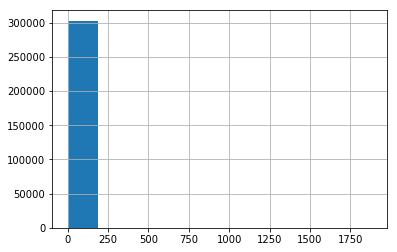

count    302989.000000
mean          2.524927
std           8.472599
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1884.000000
dtype: float64


In [184]:
counts = pd.Series([v for k,v in counter.items()], index = [k for k,v in counter.items()])
counts.hist()

plt.show()
print(counts.describe())


In [185]:
counts[counts.argsort()[::-1]]
# 5984c6fbb6b113623d63851f
# 'способ производства инстант-порошка из растительного сырья'

5984c6fbb6b113623d63851f    1884
5984c297b6b11331626384f3    1298
5984b582b6b11303ba638525    1280
5984c11bb6b1131e66638511     859
5984b7d5b6b1132953638517     845
5984b97bb6b11340306384fd     797
5984b9fbb6b11348ac63852c     771
5984b808b6b1132b9a638514     700
5984be8bb6b1137ec063851e     694
5984b896b6b113354263853f     614
5984c477b6b113450263854b     591
5984c094b6b11319de638516     548
5984b694b6b113159e638510     529
5984bd8fb6b113730f638548     522
5984b7e9b6b1132a8563850f     518
5984bb4ab6b113587963852a     514
5984c472b6b113450863853a     509
5984c446b6b11343ad638544     501
5984c564b6b113508f638536     486
5984bcd7b6b11368ff63851f     484
5984c477b6b113450263854c     454
5984b960b6b1133ef1638517     445
5984c70bb6b113633c6384f6     431
5984ba88b6b1134d6d63851c     416
5984c711b6b113634963850a     416
5984bc90b6b11366a5638501     401
5984c283b6b1133010638549     382
5984be8bb6b1137ec063851d     377
5984bd80b6b1137302638501     372
5984c4b3b6b11347a2638503     353
          

# Save b560 valid links to mongo

In [198]:
client = MongoClient()
db = client.fips

for k,v in tqdm(res.items()):
    db.patents.update_one({'_id': ObjectId(k)}, {"$set": {'similar':v}}, upsert=False)

100%|██████████| 368458/368458 [07:26<00:00, 825.23it/s] 


# Get w2v

##### tokenize docs and save for fast access

In [2]:
client = MongoClient()
db = client.fips

def json2text(doc):
    text = ''
    if 'name' in doc:
        text += doc['name'] + '.\n'
    if 'abstract' in doc:
        text += doc['abstract'] + '.\n'
    if 'description' in doc:
        text += doc['description'] + '.\n'
    if 'claims' in doc:
        text += doc['claims']

    return text

In [5]:
# db.patents.update_many({}, {'$unset': {'tokenized':1}})

/home/administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  """Entry point for launching an IPython kernel.


{'n': 1266940, 'nModified': 1266940, 'ok': 1, 'updatedExisting': True}

In [4]:
# db.corpus.update_one({'tokenized': 'simple'}, {'$set': {'docs':[]}})

def save_corpus(ids, prefix):
    client = MongoClient()
    db = client.fips
    
    docs = {}
    
    for _id in ids:
        doc_tokenized = []
        
        doc = db.patents.find_one({'_id': _id}, 
                                  {'name': 1, 'abstract': 1, 
                                   'description': 1, 'claims': 1})
        text = json2text(doc)
        for sentence in nltk.sent_tokenize(text):
            tokenized_sent = list(tokenize(sentence, stop_list=simple_stop_list))
            if len(tokenized_sent) > 1:
                doc_tokenized.append(tokenized_sent)
        
        docs[str(_id)] = doc_tokenized
    
    fname = join(DATA_FOLDER, 'documents/%s' % prefix + '.json.gz')
    with GzipFile(fname, 'w') as fout:
        json_str = json.dumps(docs)
        json_bytes = json_str.encode('utf-8')

        fout.write(json_bytes)

In [5]:
docs_ids = [doc['_id'] for doc in db.patents.find({}, {'_id': 1}) ]

In [ ]:
parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(save_corpus)(list_block, i) for 
                  i, list_block in enumerate(grouper(len(docs_ids)//1000, docs_ids)) ) 
result = parallelizer( tasks_iterator )

In [ ]:
! echo 'finished json2text' >> ../data/out

##### check

In [15]:
pprint(json2text(db.patents.find_one({'_id': docs_ids[33]})))

('запоминать устройство и способ управление он\n'
 '.\n'
 ' изобретение относиться к электронный техника и мочь быть использовать при '
 'создание интегральный \n'
 '\n'
 'микросхема запоминать устройство (зу) с энергонезависимый хранение '
 'информация.  известный запоминать устройство (зу), содержать схема '
 'управление и накопитель на мдп-транзистор с \n'
 '\n'
 'изменять порог на основа двуслойный диэлектрик, выполнять на эпитаксиальный '
 'пленка полупроводник, где запись и стирание осуществляться подача импульс '
 'напряжение на полевой электрод и \n'
 '\n'
 'подложка.  его недостаток являться малый плотность компоновка ячейка память '
 'вследствие разделение подложка элемент память в строка, малый время хранение '
 'информация из-за \n'
 'использование \n'
 'туннельный-прозрачный слой окисел как для электрон, так и для дырка, а также '
 'сложность схема управление, поскольку в данный зу необходимо подавать '
 'высоковольтный импульс запись и \n'
 'стирание как на \n'
 'полевой 

In [16]:
fn = join(DATA_FOLDER, 'documents/0.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
docs = json.loads(text)
docs[str(docs_ids[33])]


[['запоминать', 'устройство', 'способ', 'управление'],
 ['изобретение',
  'относиться',
  'электронный',
  'техника',
  'мочь',
  'использовать',
  'создание',
  'интегральный',
  'микросхема',
  'запоминать',
  'устройство',
  'зу',
  'энергонезависимый',
  'хранение',
  'информация'],
 ['известный',
  'запоминать',
  'устройство',
  'зу',
  'содержать',
  'схема',
  'управление',
  'накопитель',
  'мдп',
  'транзистор',
  'изменять',
  'порог',
  'основа',
  'двуслойный',
  'диэлектрик',
  'выполнять',
  'эпитаксиальный',
  'пленка',
  'полупроводник',
  'запись',
  'стирание',
  'осуществляться',
  'подача',
  'импульс',
  'напряжение',
  'полевой',
  'электрод',
  'подложка'],
 ['недостаток',
  'являться',
  'малый',
  'плотность',
  'компоновка',
  'ячейка',
  'память',
  'вследствие',
  'разделение',
  'подложка',
  'элемент',
  'память',
  'строка',
  'малый',
  'время',
  'хранение',
  'информация',
  'использование',
  'туннельный',
  'прозрачный',
  'слой',
  'окисел',
  'эле

In [9]:
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)

In [13]:
def get_len(list_gz):
    unpacked_list =[json.loads(GzipFile(fn, 'r').read()) for fn in tqdm(list_gz)]
    lens = [sum([len(s) for s in doc]) for docs in unpacked_list for k,doc in docs.items()]
    return lens

parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(get_len)(list_gz) for 
                  list_gz in grouper(1, ziped_files) ) 
result = parallelizer( tasks_iterator )

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


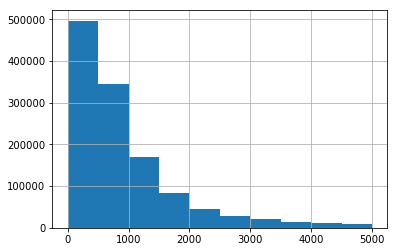

count    1.266940e+06
mean     1.181864e+03
std      2.160956e+03
min      0.000000e+00
25%      2.280000e+02
50%      6.760000e+02
75%      1.275000e+03
max      1.290420e+05
dtype: float64

In [17]:
lens = pd.Series(sum(result, []))

lens[lens<5000].hist()
plt.show()
lens.describe()

##### w2v algo

In [18]:
# iter only over 

class Sentences(object):
    def __init__(self, folder):
        self.folder = folder
 
    def __iter__(self):
        for fn in glob(join(self.folder, '*.gz')):
            with GzipFile(fn, 'r') as myzip:
                text = myzip.read()
            docs = json.loads(text)
            for k, doc in docs.items():
                for sentence in doc:
                    yield sentence

In [ ]:
dim = 300
model = Word2Vec(Sentences(join(DATA_FOLDER, 'documents/')), size=dim, 
                 sg=1, min_count=5, window=10, workers=cpu_count)

2017-08-10 00:18:29,653 : INFO : collecting all words and their counts
2017-08-10 00:18:30,286 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-08-10 00:18:30,378 : INFO : PROGRESS: at sentence #10000, processed 287708 words, keeping 13095 word types
2017-08-10 00:18:34,903 : INFO : PROGRESS: at sentence #20000, processed 554381 words, keeping 18728 word types
2017-08-10 00:18:34,957 : INFO : PROGRESS: at sentence #30000, processed 745650 words, keeping 23117 word types
2017-08-10 00:18:35,013 : INFO : PROGRESS: at sentence #40000, processed 942636 words, keeping 27035 word types
2017-08-10 00:18:35,070 : INFO : PROGRESS: at sentence #50000, processed 1140524 words, keeping 29744 word types
2017-08-10 00:18:35,130 : INFO : PROGRESS: at sentence #60000, processed 1339316 words, keeping 32970 word types
2017-08-10 00:18:35,190 : INFO : PROGRESS: at sentence #70000, processed 1536220 words, keeping 35778 word types
2017-08-10 00:18:35,246 : INFO : PROGRESS: 

2017-08-10 00:18:55,427 : INFO : PROGRESS: at sentence #720000, processed 14630285 words, keeping 136140 word types
2017-08-10 00:18:55,489 : INFO : PROGRESS: at sentence #730000, processed 14833247 words, keeping 137552 word types
2017-08-10 00:18:55,549 : INFO : PROGRESS: at sentence #740000, processed 15026582 words, keeping 138382 word types
2017-08-10 00:18:55,630 : INFO : PROGRESS: at sentence #750000, processed 15217185 words, keeping 139276 word types
2017-08-10 00:18:55,695 : INFO : PROGRESS: at sentence #760000, processed 15415666 words, keeping 140309 word types
2017-08-10 00:18:55,757 : INFO : PROGRESS: at sentence #770000, processed 15618500 words, keeping 141095 word types
2017-08-10 00:18:55,829 : INFO : PROGRESS: at sentence #780000, processed 15843920 words, keeping 142416 word types
2017-08-10 00:18:55,895 : INFO : PROGRESS: at sentence #790000, processed 16048386 words, keeping 143644 word types
2017-08-10 00:18:55,957 : INFO : PROGRESS: at sentence #800000, processe

2017-08-10 00:19:16,524 : INFO : PROGRESS: at sentence #1430000, processed 28571370 words, keeping 233153 word types
2017-08-10 00:19:16,591 : INFO : PROGRESS: at sentence #1440000, processed 28771282 words, keeping 233980 word types
2017-08-10 00:19:16,658 : INFO : PROGRESS: at sentence #1450000, processed 28972163 words, keeping 234446 word types
2017-08-10 00:19:16,727 : INFO : PROGRESS: at sentence #1460000, processed 29169690 words, keeping 235605 word types
2017-08-10 00:19:16,794 : INFO : PROGRESS: at sentence #1470000, processed 29364079 words, keeping 236434 word types
2017-08-10 00:19:16,893 : INFO : PROGRESS: at sentence #1480000, processed 29573606 words, keeping 237642 word types
2017-08-10 00:19:16,971 : INFO : PROGRESS: at sentence #1490000, processed 29770597 words, keeping 238331 word types
2017-08-10 00:19:17,045 : INFO : PROGRESS: at sentence #1500000, processed 29956438 words, keeping 239028 word types
2017-08-10 00:19:17,124 : INFO : PROGRESS: at sentence #1510000,

2017-08-10 00:19:33,912 : INFO : PROGRESS: at sentence #2140000, processed 42499572 words, keeping 303115 word types
2017-08-10 00:19:35,198 : INFO : PROGRESS: at sentence #2150000, processed 42676328 words, keeping 304739 word types
2017-08-10 00:19:35,280 : INFO : PROGRESS: at sentence #2160000, processed 42885414 words, keeping 308144 word types
2017-08-10 00:19:35,365 : INFO : PROGRESS: at sentence #2170000, processed 43100054 words, keeping 311783 word types
2017-08-10 00:19:35,447 : INFO : PROGRESS: at sentence #2180000, processed 43310057 words, keeping 315538 word types
2017-08-10 00:19:35,525 : INFO : PROGRESS: at sentence #2190000, processed 43517448 words, keeping 317783 word types
2017-08-10 00:19:37,377 : INFO : PROGRESS: at sentence #2200000, processed 43743577 words, keeping 319346 word types
2017-08-10 00:19:37,453 : INFO : PROGRESS: at sentence #2210000, processed 43944234 words, keeping 320091 word types
2017-08-10 00:19:37,530 : INFO : PROGRESS: at sentence #2220000,

2017-08-10 00:19:57,620 : INFO : PROGRESS: at sentence #2850000, processed 57175925 words, keeping 364366 word types
2017-08-10 00:19:57,690 : INFO : PROGRESS: at sentence #2860000, processed 57366602 words, keeping 365088 word types
2017-08-10 00:19:57,771 : INFO : PROGRESS: at sentence #2870000, processed 57586010 words, keeping 365662 word types
2017-08-10 00:19:57,859 : INFO : PROGRESS: at sentence #2880000, processed 57800674 words, keeping 366757 word types
2017-08-10 00:19:57,942 : INFO : PROGRESS: at sentence #2890000, processed 58003849 words, keeping 367528 word types
2017-08-10 00:19:58,025 : INFO : PROGRESS: at sentence #2900000, processed 58209207 words, keeping 368150 word types
2017-08-10 00:19:58,707 : INFO : PROGRESS: at sentence #2910000, processed 58483407 words, keeping 369003 word types
2017-08-10 00:20:00,064 : INFO : PROGRESS: at sentence #2920000, processed 58743454 words, keeping 370614 word types
2017-08-10 00:20:00,145 : INFO : PROGRESS: at sentence #2930000,

2017-08-10 00:20:20,555 : INFO : PROGRESS: at sentence #3560000, processed 72336272 words, keeping 440467 word types
2017-08-10 00:20:20,644 : INFO : PROGRESS: at sentence #3570000, processed 72540221 words, keeping 440912 word types
2017-08-10 00:20:20,731 : INFO : PROGRESS: at sentence #3580000, processed 72735722 words, keeping 441592 word types
2017-08-10 00:20:20,825 : INFO : PROGRESS: at sentence #3590000, processed 72948869 words, keeping 442386 word types
2017-08-10 00:20:21,515 : INFO : PROGRESS: at sentence #3600000, processed 73233094 words, keeping 442987 word types
2017-08-10 00:20:22,667 : INFO : PROGRESS: at sentence #3610000, processed 73487814 words, keeping 443542 word types
2017-08-10 00:20:22,756 : INFO : PROGRESS: at sentence #3620000, processed 73718290 words, keeping 445369 word types
2017-08-10 00:20:22,848 : INFO : PROGRESS: at sentence #3630000, processed 73953425 words, keeping 445789 word types
2017-08-10 00:20:22,939 : INFO : PROGRESS: at sentence #3640000,

2017-08-10 00:20:43,721 : INFO : PROGRESS: at sentence #4270000, processed 86648565 words, keeping 484702 word types
2017-08-10 00:20:43,812 : INFO : PROGRESS: at sentence #4280000, processed 86852957 words, keeping 485650 word types
2017-08-10 00:20:43,903 : INFO : PROGRESS: at sentence #4290000, processed 87041268 words, keeping 486245 word types
2017-08-10 00:20:43,985 : INFO : PROGRESS: at sentence #4300000, processed 87228836 words, keeping 486930 word types
2017-08-10 00:20:44,066 : INFO : PROGRESS: at sentence #4310000, processed 87419134 words, keeping 487471 word types
2017-08-10 00:20:44,455 : INFO : PROGRESS: at sentence #4320000, processed 87599821 words, keeping 488085 word types
2017-08-10 00:20:48,072 : INFO : PROGRESS: at sentence #4330000, processed 87791972 words, keeping 488698 word types
2017-08-10 00:20:48,155 : INFO : PROGRESS: at sentence #4340000, processed 87989695 words, keeping 489217 word types
2017-08-10 00:20:48,242 : INFO : PROGRESS: at sentence #4350000,

2017-08-10 00:21:08,161 : INFO : PROGRESS: at sentence #4970000, processed 100741181 words, keeping 537735 word types
2017-08-10 00:21:08,249 : INFO : PROGRESS: at sentence #4980000, processed 100956235 words, keeping 538326 word types
2017-08-10 00:21:08,332 : INFO : PROGRESS: at sentence #4990000, processed 101140570 words, keeping 539061 word types
2017-08-10 00:21:08,417 : INFO : PROGRESS: at sentence #5000000, processed 101344310 words, keeping 539376 word types
2017-08-10 00:21:08,496 : INFO : PROGRESS: at sentence #5010000, processed 101525527 words, keeping 540217 word types
2017-08-10 00:21:08,579 : INFO : PROGRESS: at sentence #5020000, processed 101713833 words, keeping 540844 word types
2017-08-10 00:21:08,661 : INFO : PROGRESS: at sentence #5030000, processed 101902955 words, keeping 541387 word types
2017-08-10 00:21:08,740 : INFO : PROGRESS: at sentence #5040000, processed 102092596 words, keeping 542076 word types
2017-08-10 00:21:08,826 : INFO : PROGRESS: at sentence #

2017-08-10 06:29:56,495 : INFO : PROGRESS: at 14.94% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:29:57,697 : INFO : PROGRESS: at 14.94% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:29:58,753 : INFO : PROGRESS: at 14.95% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:29:59,868 : INFO : PROGRESS: at 14.95% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:30:01,183 : INFO : PROGRESS: at 14.95% examples, 55312 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:30:02,436 : INFO : PROGRESS: at 14.95% examples, 55312 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:30:03,495 : INFO : PROGRESS: at 14.95% examples, 55312 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:30:04,651 : INFO : PROGRESS: at 14.95% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:30:05,775 : INFO : PROGRESS: at 14.95% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:30:06,806 : INFO : PROGRESS: at 14.95% examples, 55311 words/s, in_q

2017-08-10 06:31:38,509 : INFO : PROGRESS: at 15.02% examples, 55300 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:31:39,818 : INFO : PROGRESS: at 15.02% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:31:40,863 : INFO : PROGRESS: at 15.02% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:31:41,947 : INFO : PROGRESS: at 15.02% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:31:43,069 : INFO : PROGRESS: at 15.02% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:31:44,183 : INFO : PROGRESS: at 15.02% examples, 55302 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:31:45,216 : INFO : PROGRESS: at 15.02% examples, 55302 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:31:46,353 : INFO : PROGRESS: at 15.02% examples, 55302 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:31:47,442 : INFO : PROGRESS: at 15.02% examples, 55302 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:31:48,565 : INFO : PROGRESS: at 15.02% examples, 55302 words/s, in_q

2017-08-10 06:33:16,237 : INFO : PROGRESS: at 15.09% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:33:17,471 : INFO : PROGRESS: at 15.09% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:33:18,490 : INFO : PROGRESS: at 15.10% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:33:19,505 : INFO : PROGRESS: at 15.10% examples, 55309 words/s, in_qsize 6, out_qsize 1
2017-08-10 06:33:20,788 : INFO : PROGRESS: at 15.10% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:33:22,142 : INFO : PROGRESS: at 15.10% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:33:23,200 : INFO : PROGRESS: at 15.10% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:33:24,272 : INFO : PROGRESS: at 15.10% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:33:25,334 : INFO : PROGRESS: at 15.10% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:33:26,500 : INFO : PROGRESS: at 15.10% examples, 55310 words/s, in_q

2017-08-10 06:34:54,293 : INFO : PROGRESS: at 15.16% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:34:55,454 : INFO : PROGRESS: at 15.16% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:34:56,519 : INFO : PROGRESS: at 15.16% examples, 55310 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:34:57,523 : INFO : PROGRESS: at 15.16% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:34:58,578 : INFO : PROGRESS: at 15.16% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:34:59,688 : INFO : PROGRESS: at 15.16% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:35:00,698 : INFO : PROGRESS: at 15.16% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:35:01,737 : INFO : PROGRESS: at 15.17% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:35:02,958 : INFO : PROGRESS: at 15.17% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:35:03,963 : INFO : PROGRESS: at 15.17% examples, 55312 words/s, in_q

2017-08-10 06:36:34,263 : INFO : PROGRESS: at 15.24% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:35,334 : INFO : PROGRESS: at 15.24% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:36,337 : INFO : PROGRESS: at 15.24% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:37,599 : INFO : PROGRESS: at 15.24% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:38,818 : INFO : PROGRESS: at 15.24% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:40,052 : INFO : PROGRESS: at 15.24% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:41,143 : INFO : PROGRESS: at 15.25% examples, 55313 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:42,252 : INFO : PROGRESS: at 15.25% examples, 55313 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:43,419 : INFO : PROGRESS: at 15.25% examples, 55313 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:36:44,512 : INFO : PROGRESS: at 15.25% examples, 55313 words/s, in_q

2017-08-10 06:38:16,038 : INFO : PROGRESS: at 15.32% examples, 55314 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:17,388 : INFO : PROGRESS: at 15.33% examples, 55314 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:18,649 : INFO : PROGRESS: at 15.33% examples, 55314 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:20,075 : INFO : PROGRESS: at 15.33% examples, 55314 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:21,310 : INFO : PROGRESS: at 15.33% examples, 55315 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:22,589 : INFO : PROGRESS: at 15.33% examples, 55315 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:23,837 : INFO : PROGRESS: at 15.33% examples, 55315 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:24,940 : INFO : PROGRESS: at 15.33% examples, 55316 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:25,971 : INFO : PROGRESS: at 15.33% examples, 55316 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:38:27,023 : INFO : PROGRESS: at 15.33% examples, 55316 words/s, in_q

2017-08-10 06:39:57,613 : INFO : PROGRESS: at 15.40% examples, 55318 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:39:58,914 : INFO : PROGRESS: at 15.41% examples, 55318 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:40:00,245 : INFO : PROGRESS: at 15.41% examples, 55318 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:40:01,256 : INFO : PROGRESS: at 15.41% examples, 55318 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:40:02,358 : INFO : PROGRESS: at 15.41% examples, 55318 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:40:03,419 : INFO : PROGRESS: at 15.41% examples, 55319 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:40:04,598 : INFO : PROGRESS: at 15.41% examples, 55317 words/s, in_qsize 4, out_qsize 2
2017-08-10 06:40:05,872 : INFO : PROGRESS: at 15.41% examples, 55317 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:40:06,924 : INFO : PROGRESS: at 15.41% examples, 55318 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:40:08,326 : INFO : PROGRESS: at 15.41% examples, 55317 words/s, in_q

2017-08-10 06:41:39,956 : INFO : PROGRESS: at 15.48% examples, 55313 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:41:40,973 : INFO : PROGRESS: at 15.48% examples, 55312 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:41:42,261 : INFO : PROGRESS: at 15.48% examples, 55313 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:41:43,348 : INFO : PROGRESS: at 15.48% examples, 55313 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:41:44,437 : INFO : PROGRESS: at 15.48% examples, 55313 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:41:45,498 : INFO : PROGRESS: at 15.48% examples, 55314 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:41:46,819 : INFO : PROGRESS: at 15.48% examples, 55313 words/s, in_qsize 8, out_qsize 1
2017-08-10 06:41:48,087 : INFO : PROGRESS: at 15.49% examples, 55314 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:41:49,105 : INFO : PROGRESS: at 15.49% examples, 55314 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:41:50,321 : INFO : PROGRESS: at 15.49% examples, 55314 words/s, in_q

2017-08-10 06:43:20,747 : INFO : PROGRESS: at 15.56% examples, 55311 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:43:21,783 : INFO : PROGRESS: at 15.56% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:43:22,915 : INFO : PROGRESS: at 15.56% examples, 55311 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:43:24,263 : INFO : PROGRESS: at 15.56% examples, 55311 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:43:25,591 : INFO : PROGRESS: at 15.56% examples, 55311 words/s, in_qsize 6, out_qsize 1
2017-08-10 06:43:26,804 : INFO : PROGRESS: at 15.56% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:43:28,109 : INFO : PROGRESS: at 15.56% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:43:29,355 : INFO : PROGRESS: at 15.57% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:43:30,400 : INFO : PROGRESS: at 15.57% examples, 55312 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:43:31,426 : INFO : PROGRESS: at 15.57% examples, 55313 words/s, in_q

2017-08-10 06:45:02,851 : INFO : PROGRESS: at 15.64% examples, 55312 words/s, in_qsize 2, out_qsize 0
2017-08-10 06:45:07,894 : INFO : PROGRESS: at 15.64% examples, 55301 words/s, in_qsize 0, out_qsize 0
2017-08-10 06:45:09,438 : INFO : PROGRESS: at 15.64% examples, 55300 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:45:10,751 : INFO : PROGRESS: at 15.64% examples, 55300 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:45:11,878 : INFO : PROGRESS: at 15.64% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:45:13,043 : INFO : PROGRESS: at 15.64% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:45:14,072 : INFO : PROGRESS: at 15.64% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:45:15,077 : INFO : PROGRESS: at 15.64% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:45:16,449 : INFO : PROGRESS: at 15.65% examples, 55301 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:45:17,846 : INFO : PROGRESS: at 15.65% examples, 55301 words/s, in_q

2017-08-10 06:46:46,589 : INFO : PROGRESS: at 15.72% examples, 55308 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:46:47,608 : INFO : PROGRESS: at 15.72% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:46:48,626 : INFO : PROGRESS: at 15.72% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:46:49,687 : INFO : PROGRESS: at 15.72% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:46:50,688 : INFO : PROGRESS: at 15.72% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:46:51,809 : INFO : PROGRESS: at 15.72% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:46:52,895 : INFO : PROGRESS: at 15.72% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:46:54,171 : INFO : PROGRESS: at 15.72% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:46:55,546 : INFO : PROGRESS: at 15.72% examples, 55309 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:46:56,864 : INFO : PROGRESS: at 15.73% examples, 55309 words/s, in_q

2017-08-10 06:48:27,933 : INFO : PROGRESS: at 15.79% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:48:28,934 : INFO : PROGRESS: at 15.79% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:48:30,010 : INFO : PROGRESS: at 15.79% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:48:31,051 : INFO : PROGRESS: at 15.79% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:48:32,372 : INFO : PROGRESS: at 15.80% examples, 55309 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:48:33,387 : INFO : PROGRESS: at 15.80% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:48:34,557 : INFO : PROGRESS: at 15.80% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:48:35,710 : INFO : PROGRESS: at 15.80% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:48:36,795 : INFO : PROGRESS: at 15.80% examples, 55309 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:48:37,884 : INFO : PROGRESS: at 15.80% examples, 55310 words/s, in_q

2017-08-10 06:50:05,813 : INFO : PROGRESS: at 15.86% examples, 55303 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:50:06,901 : INFO : PROGRESS: at 15.87% examples, 55303 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:50:07,958 : INFO : PROGRESS: at 15.87% examples, 55303 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:50:09,159 : INFO : PROGRESS: at 15.87% examples, 55303 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:50:10,161 : INFO : PROGRESS: at 15.87% examples, 55303 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:50:11,471 : INFO : PROGRESS: at 15.87% examples, 55303 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:50:12,480 : INFO : PROGRESS: at 15.87% examples, 55303 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:50:13,816 : INFO : PROGRESS: at 15.87% examples, 55303 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:50:15,285 : INFO : PROGRESS: at 15.87% examples, 55303 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:50:16,942 : INFO : PROGRESS: at 15.87% examples, 55302 words/s, in_q

2017-08-10 06:51:46,773 : INFO : PROGRESS: at 15.94% examples, 55297 words/s, in_qsize 7, out_qsize 2
2017-08-10 06:51:48,155 : INFO : PROGRESS: at 15.94% examples, 55298 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:51:49,582 : INFO : PROGRESS: at 15.94% examples, 55297 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:51:51,073 : INFO : PROGRESS: at 15.94% examples, 55297 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:51:52,423 : INFO : PROGRESS: at 15.94% examples, 55295 words/s, in_qsize 1, out_qsize 3
2017-08-10 06:51:53,833 : INFO : PROGRESS: at 15.94% examples, 55295 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:51:55,280 : INFO : PROGRESS: at 15.94% examples, 55295 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:51:56,628 : INFO : PROGRESS: at 15.94% examples, 55295 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:51:57,988 : INFO : PROGRESS: at 15.94% examples, 55296 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:51:58,997 : INFO : PROGRESS: at 15.94% examples, 55296 words/s, in_q

2017-08-10 06:53:28,019 : INFO : PROGRESS: at 16.01% examples, 55289 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:53:29,273 : INFO : PROGRESS: at 16.01% examples, 55289 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:53:30,465 : INFO : PROGRESS: at 16.01% examples, 55290 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:53:31,809 : INFO : PROGRESS: at 16.02% examples, 55290 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:53:32,827 : INFO : PROGRESS: at 16.02% examples, 55291 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:53:34,052 : INFO : PROGRESS: at 16.02% examples, 55291 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:53:35,079 : INFO : PROGRESS: at 16.02% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:53:36,170 : INFO : PROGRESS: at 16.02% examples, 55293 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:53:37,306 : INFO : PROGRESS: at 16.02% examples, 55294 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:53:38,458 : INFO : PROGRESS: at 16.02% examples, 55295 words/s, in_q

2017-08-10 06:55:07,411 : INFO : PROGRESS: at 16.09% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:08,413 : INFO : PROGRESS: at 16.09% examples, 55291 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:09,553 : INFO : PROGRESS: at 16.09% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:10,954 : INFO : PROGRESS: at 16.09% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:12,332 : INFO : PROGRESS: at 16.09% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:13,722 : INFO : PROGRESS: at 16.09% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:14,903 : INFO : PROGRESS: at 16.09% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:16,161 : INFO : PROGRESS: at 16.10% examples, 55293 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:17,204 : INFO : PROGRESS: at 16.10% examples, 55293 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:55:18,372 : INFO : PROGRESS: at 16.10% examples, 55293 words/s, in_q

2017-08-10 06:56:47,623 : INFO : PROGRESS: at 16.16% examples, 55290 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:48,814 : INFO : PROGRESS: at 16.16% examples, 55290 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:50,096 : INFO : PROGRESS: at 16.17% examples, 55291 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:51,469 : INFO : PROGRESS: at 16.17% examples, 55291 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:52,803 : INFO : PROGRESS: at 16.17% examples, 55291 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:54,118 : INFO : PROGRESS: at 16.17% examples, 55291 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:55,439 : INFO : PROGRESS: at 16.17% examples, 55291 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:56,737 : INFO : PROGRESS: at 16.17% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:57,969 : INFO : PROGRESS: at 16.17% examples, 55292 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:56:59,017 : INFO : PROGRESS: at 16.17% examples, 55292 words/s, in_q

2017-08-10 06:58:30,908 : INFO : PROGRESS: at 16.24% examples, 55286 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:58:31,935 : INFO : PROGRESS: at 16.24% examples, 55287 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:58:33,016 : INFO : PROGRESS: at 16.24% examples, 55286 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:58:34,033 : INFO : PROGRESS: at 16.24% examples, 55287 words/s, in_qsize 8, out_qsize 0
2017-08-10 06:58:35,069 : INFO : PROGRESS: at 16.24% examples, 55286 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:58:36,389 : INFO : PROGRESS: at 16.24% examples, 55286 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:58:37,713 : INFO : PROGRESS: at 16.25% examples, 55287 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:58:39,065 : INFO : PROGRESS: at 16.25% examples, 55287 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:58:40,426 : INFO : PROGRESS: at 16.25% examples, 55287 words/s, in_qsize 7, out_qsize 0
2017-08-10 06:58:41,736 : INFO : PROGRESS: at 16.25% examples, 55287 words/s, in_q

2017-08-10 07:48:55,377 : INFO : PROGRESS: at 18.53% examples, 55184 words/s, in_qsize 7, out_qsize 0
2017-08-10 07:48:56,419 : INFO : PROGRESS: at 18.54% examples, 55185 words/s, in_qsize 7, out_qsize 0
2017-08-10 07:48:57,430 : INFO : PROGRESS: at 18.54% examples, 55185 words/s, in_qsize 7, out_qsize 0
2017-08-10 07:48:58,620 : INFO : PROGRESS: at 18.54% examples, 55185 words/s, in_qsize 7, out_qsize 0
2017-08-10 07:49:00,049 : INFO : PROGRESS: at 18.54% examples, 55185 words/s, in_qsize 7, out_qsize 0
2017-08-10 07:49:01,376 : INFO : PROGRESS: at 18.54% examples, 55185 words/s, in_qsize 7, out_qsize 0
2017-08-10 07:49:02,913 : INFO : PROGRESS: at 18.54% examples, 55184 words/s, in_qsize 5, out_qsize 1
2017-08-10 07:49:04,125 : INFO : PROGRESS: at 18.54% examples, 55182 words/s, in_qsize 5, out_qsize 0
2017-08-10 07:49:05,455 : INFO : PROGRESS: at 18.54% examples, 55183 words/s, in_qsize 7, out_qsize 0
2017-08-10 07:49:06,773 : INFO : PROGRESS: at 18.54% examples, 55183 words/s, in_q

2017-08-10 08:12:33,798 : INFO : PROGRESS: at 19.61% examples, 55142 words/s, in_qsize 8, out_qsize 1
2017-08-10 08:12:35,129 : INFO : PROGRESS: at 19.61% examples, 55142 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:12:36,453 : INFO : PROGRESS: at 19.61% examples, 55142 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:12:37,792 : INFO : PROGRESS: at 19.61% examples, 55142 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:12:39,110 : INFO : PROGRESS: at 19.61% examples, 55142 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:12:40,142 : INFO : PROGRESS: at 19.61% examples, 55143 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:12:41,336 : INFO : PROGRESS: at 19.61% examples, 55143 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:12:42,601 : INFO : PROGRESS: at 19.61% examples, 55143 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:12:43,630 : INFO : PROGRESS: at 19.61% examples, 55143 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:12:44,836 : INFO : PROGRESS: at 19.62% examples, 55143 words/s, in_q

2017-08-10 08:14:13,207 : INFO : PROGRESS: at 19.68% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:14:14,355 : INFO : PROGRESS: at 19.68% examples, 55138 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:14:15,595 : INFO : PROGRESS: at 19.68% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:14:16,896 : INFO : PROGRESS: at 19.68% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:14:17,973 : INFO : PROGRESS: at 19.68% examples, 55138 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:14:19,106 : INFO : PROGRESS: at 19.68% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:14:20,211 : INFO : PROGRESS: at 19.68% examples, 55138 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:14:21,237 : INFO : PROGRESS: at 19.68% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:14:22,369 : INFO : PROGRESS: at 19.69% examples, 55139 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:14:23,377 : INFO : PROGRESS: at 19.69% examples, 55139 words/s, in_q

2017-08-10 08:15:49,665 : INFO : PROGRESS: at 19.75% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:50,679 : INFO : PROGRESS: at 19.75% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:51,709 : INFO : PROGRESS: at 19.75% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:52,839 : INFO : PROGRESS: at 19.75% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:54,071 : INFO : PROGRESS: at 19.75% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:55,103 : INFO : PROGRESS: at 19.75% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:56,147 : INFO : PROGRESS: at 19.75% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:57,149 : INFO : PROGRESS: at 19.75% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:58,508 : INFO : PROGRESS: at 19.76% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:15:59,869 : INFO : PROGRESS: at 19.76% examples, 55138 words/s, in_q

2017-08-10 08:17:31,276 : INFO : PROGRESS: at 19.83% examples, 55135 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:32,318 : INFO : PROGRESS: at 19.83% examples, 55135 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:33,593 : INFO : PROGRESS: at 19.83% examples, 55135 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:34,951 : INFO : PROGRESS: at 19.83% examples, 55135 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:36,314 : INFO : PROGRESS: at 19.83% examples, 55135 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:37,493 : INFO : PROGRESS: at 19.83% examples, 55136 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:38,517 : INFO : PROGRESS: at 19.83% examples, 55136 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:39,745 : INFO : PROGRESS: at 19.83% examples, 55136 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:40,778 : INFO : PROGRESS: at 19.83% examples, 55136 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:17:41,942 : INFO : PROGRESS: at 19.83% examples, 55136 words/s, in_q

2017-08-10 08:19:11,370 : INFO : PROGRESS: at 19.91% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:19:12,539 : INFO : PROGRESS: at 19.91% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:19:13,573 : INFO : PROGRESS: at 19.91% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:19:14,870 : INFO : PROGRESS: at 19.91% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:19:16,190 : INFO : PROGRESS: at 19.91% examples, 55138 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:19:17,489 : INFO : PROGRESS: at 19.91% examples, 55139 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:19:18,771 : INFO : PROGRESS: at 19.91% examples, 55139 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:19:20,108 : INFO : PROGRESS: at 19.91% examples, 55139 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:19:21,311 : INFO : PROGRESS: at 19.91% examples, 55137 words/s, in_qsize 5, out_qsize 1
2017-08-10 08:19:22,850 : INFO : PROGRESS: at 19.91% examples, 55137 words/s, in_q

2017-08-10 08:20:51,804 : INFO : PROGRESS: at 19.98% examples, 55138 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:20:53,010 : INFO : PROGRESS: at 19.98% examples, 55139 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:20:54,125 : INFO : PROGRESS: at 19.98% examples, 55139 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:20:55,272 : INFO : PROGRESS: at 19.99% examples, 55139 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:20:56,379 : INFO : PROGRESS: at 19.99% examples, 55140 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:20:57,527 : INFO : PROGRESS: at 19.99% examples, 55140 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:20:58,560 : INFO : PROGRESS: at 19.99% examples, 55140 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:20:59,820 : INFO : PROGRESS: at 19.99% examples, 55140 words/s, in_qsize 8, out_qsize 0
2017-08-10 08:21:00,862 : INFO : PROGRESS: at 19.99% examples, 55140 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:21:02,098 : INFO : PROGRESS: at 19.99% examples, 55141 words/s, in_q

2017-08-10 08:22:31,331 : INFO : PROGRESS: at 20.06% examples, 55141 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:22:32,352 : INFO : PROGRESS: at 20.06% examples, 55141 words/s, in_qsize 1, out_qsize 0
2017-08-10 08:22:33,485 : INFO : PROGRESS: at 20.06% examples, 55140 words/s, in_qsize 0, out_qsize 2
2017-08-10 08:22:39,327 : INFO : PROGRESS: at 20.06% examples, 55129 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:22:40,606 : INFO : PROGRESS: at 20.06% examples, 55129 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:22:41,971 : INFO : PROGRESS: at 20.06% examples, 55129 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:22:43,257 : INFO : PROGRESS: at 20.07% examples, 55129 words/s, in_qsize 6, out_qsize 1
2017-08-10 08:22:44,460 : INFO : PROGRESS: at 20.07% examples, 55130 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:22:45,712 : INFO : PROGRESS: at 20.07% examples, 55130 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:22:46,822 : INFO : PROGRESS: at 20.07% examples, 55130 words/s, in_q

2017-08-10 08:24:10,814 : INFO : PROGRESS: at 20.14% examples, 55147 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:24:11,869 : INFO : PROGRESS: at 20.14% examples, 55147 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:24:14,485 : INFO : PROGRESS: at 20.15% examples, 55144 words/s, in_qsize 2, out_qsize 2
2017-08-10 08:24:15,567 : INFO : PROGRESS: at 20.15% examples, 55144 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:24:16,937 : INFO : PROGRESS: at 20.15% examples, 55144 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:24:18,289 : INFO : PROGRESS: at 20.15% examples, 55144 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:24:19,349 : INFO : PROGRESS: at 20.15% examples, 55145 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:24:20,445 : INFO : PROGRESS: at 20.15% examples, 55144 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:24:21,469 : INFO : PROGRESS: at 20.15% examples, 55145 words/s, in_qsize 7, out_qsize 0
2017-08-10 08:24:22,817 : INFO : PROGRESS: at 20.15% examples, 55144 words/s, in_q

2017-08-10 09:24:04,088 : INFO : PROGRESS: at 22.87% examples, 55134 words/s, in_qsize 6, out_qsize 1
2017-08-10 09:24:05,423 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_qsize 4, out_qsize 2
2017-08-10 09:24:06,700 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:24:08,122 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:24:09,502 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:24:10,973 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_qsize 5, out_qsize 0
2017-08-10 09:24:12,110 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:24:13,149 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:24:14,183 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:24:15,220 : INFO : PROGRESS: at 22.87% examples, 55133 words/s, in_q

2017-08-10 09:25:49,348 : INFO : PROGRESS: at 22.94% examples, 55131 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:25:50,404 : INFO : PROGRESS: at 22.94% examples, 55131 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:25:51,801 : INFO : PROGRESS: at 22.94% examples, 55131 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:25:53,232 : INFO : PROGRESS: at 22.95% examples, 55131 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:25:54,525 : INFO : PROGRESS: at 22.95% examples, 55131 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:25:55,828 : INFO : PROGRESS: at 22.95% examples, 55131 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:25:56,852 : INFO : PROGRESS: at 22.95% examples, 55131 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:25:57,866 : INFO : PROGRESS: at 22.95% examples, 55132 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:25:58,927 : INFO : PROGRESS: at 22.95% examples, 55132 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:26:00,019 : INFO : PROGRESS: at 22.95% examples, 55131 words/s, in_q

2017-08-10 09:27:32,389 : INFO : PROGRESS: at 23.01% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:33,688 : INFO : PROGRESS: at 23.01% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:34,707 : INFO : PROGRESS: at 23.01% examples, 55125 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:35,720 : INFO : PROGRESS: at 23.01% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:36,782 : INFO : PROGRESS: at 23.01% examples, 55125 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:37,826 : INFO : PROGRESS: at 23.01% examples, 55125 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:38,852 : INFO : PROGRESS: at 23.01% examples, 55125 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:40,132 : INFO : PROGRESS: at 23.01% examples, 55125 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:41,153 : INFO : PROGRESS: at 23.01% examples, 55125 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:27:42,306 : INFO : PROGRESS: at 23.02% examples, 55125 words/s, in_q

2017-08-10 09:29:09,068 : INFO : PROGRESS: at 23.08% examples, 55127 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:29:10,084 : INFO : PROGRESS: at 23.08% examples, 55127 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:29:11,154 : INFO : PROGRESS: at 23.08% examples, 55127 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:29:12,207 : INFO : PROGRESS: at 23.08% examples, 55127 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:29:13,328 : INFO : PROGRESS: at 23.08% examples, 55127 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:29:14,483 : INFO : PROGRESS: at 23.08% examples, 55127 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:29:15,673 : INFO : PROGRESS: at 23.08% examples, 55128 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:29:16,826 : INFO : PROGRESS: at 23.08% examples, 55128 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:29:17,840 : INFO : PROGRESS: at 23.08% examples, 55128 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:29:18,912 : INFO : PROGRESS: at 23.08% examples, 55128 words/s, in_q

2017-08-10 09:30:46,550 : INFO : PROGRESS: at 23.14% examples, 55128 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:30:47,619 : INFO : PROGRESS: at 23.14% examples, 55128 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:30:48,829 : INFO : PROGRESS: at 23.14% examples, 55128 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:30:50,022 : INFO : PROGRESS: at 23.15% examples, 55128 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:30:51,167 : INFO : PROGRESS: at 23.15% examples, 55128 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:30:52,208 : INFO : PROGRESS: at 23.15% examples, 55129 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:30:53,391 : INFO : PROGRESS: at 23.15% examples, 55128 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:30:54,479 : INFO : PROGRESS: at 23.15% examples, 55129 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:30:55,578 : INFO : PROGRESS: at 23.15% examples, 55128 words/s, in_qsize 4, out_qsize 1
2017-08-10 09:30:57,432 : INFO : PROGRESS: at 23.15% examples, 55125 words/s, in_q

2017-08-10 09:32:26,641 : INFO : PROGRESS: at 23.22% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:27,673 : INFO : PROGRESS: at 23.22% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:28,744 : INFO : PROGRESS: at 23.22% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:29,783 : INFO : PROGRESS: at 23.22% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:30,873 : INFO : PROGRESS: at 23.22% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:31,908 : INFO : PROGRESS: at 23.22% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:32,978 : INFO : PROGRESS: at 23.22% examples, 55125 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:34,011 : INFO : PROGRESS: at 23.23% examples, 55124 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:35,364 : INFO : PROGRESS: at 23.23% examples, 55125 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:32:36,723 : INFO : PROGRESS: at 23.23% examples, 55125 words/s, in_q

2017-08-10 09:34:07,199 : INFO : PROGRESS: at 23.28% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:34:08,564 : INFO : PROGRESS: at 23.28% examples, 55113 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:34:09,583 : INFO : PROGRESS: at 23.29% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:34:10,857 : INFO : PROGRESS: at 23.29% examples, 55114 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:34:12,184 : INFO : PROGRESS: at 23.29% examples, 55114 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:34:13,185 : INFO : PROGRESS: at 23.29% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:34:14,266 : INFO : PROGRESS: at 23.29% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:34:15,686 : INFO : PROGRESS: at 23.29% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:34:17,027 : INFO : PROGRESS: at 23.29% examples, 55114 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:34:18,069 : INFO : PROGRESS: at 23.29% examples, 55114 words/s, in_q

2017-08-10 09:35:48,359 : INFO : PROGRESS: at 23.36% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:49,384 : INFO : PROGRESS: at 23.36% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:50,733 : INFO : PROGRESS: at 23.36% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:51,743 : INFO : PROGRESS: at 23.36% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:52,784 : INFO : PROGRESS: at 23.36% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:53,985 : INFO : PROGRESS: at 23.37% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:55,091 : INFO : PROGRESS: at 23.37% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:56,199 : INFO : PROGRESS: at 23.37% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:57,266 : INFO : PROGRESS: at 23.37% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:35:58,287 : INFO : PROGRESS: at 23.37% examples, 55110 words/s, in_q

2017-08-10 09:37:28,144 : INFO : PROGRESS: at 23.44% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:29,432 : INFO : PROGRESS: at 23.44% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:30,728 : INFO : PROGRESS: at 23.44% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:32,017 : INFO : PROGRESS: at 23.44% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:33,287 : INFO : PROGRESS: at 23.44% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:34,293 : INFO : PROGRESS: at 23.45% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:35,608 : INFO : PROGRESS: at 23.45% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:36,978 : INFO : PROGRESS: at 23.45% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:38,342 : INFO : PROGRESS: at 23.45% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:37:39,604 : INFO : PROGRESS: at 23.45% examples, 55113 words/s, in_q

2017-08-10 09:39:06,750 : INFO : PROGRESS: at 23.52% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:39:08,011 : INFO : PROGRESS: at 23.52% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:39:09,221 : INFO : PROGRESS: at 23.52% examples, 55115 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:39:10,295 : INFO : PROGRESS: at 23.52% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:39:11,365 : INFO : PROGRESS: at 23.52% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:39:12,409 : INFO : PROGRESS: at 23.53% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:39:13,520 : INFO : PROGRESS: at 23.53% examples, 55115 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:39:14,856 : INFO : PROGRESS: at 23.53% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:39:16,124 : INFO : PROGRESS: at 23.53% examples, 55116 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:39:17,143 : INFO : PROGRESS: at 23.53% examples, 55116 words/s, in_q

2017-08-10 09:40:50,209 : INFO : PROGRESS: at 23.59% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:40:51,574 : INFO : PROGRESS: at 23.59% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:40:52,914 : INFO : PROGRESS: at 23.59% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:40:54,231 : INFO : PROGRESS: at 23.59% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:40:55,284 : INFO : PROGRESS: at 23.60% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:40:56,324 : INFO : PROGRESS: at 23.60% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:40:57,336 : INFO : PROGRESS: at 23.60% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:40:58,409 : INFO : PROGRESS: at 23.60% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:40:59,456 : INFO : PROGRESS: at 23.60% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:41:00,460 : INFO : PROGRESS: at 23.60% examples, 55114 words/s, in_q

2017-08-10 09:42:29,092 : INFO : PROGRESS: at 23.67% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:42:30,383 : INFO : PROGRESS: at 23.67% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:42:31,763 : INFO : PROGRESS: at 23.67% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:42:33,099 : INFO : PROGRESS: at 23.67% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:42:34,394 : INFO : PROGRESS: at 23.67% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:42:35,740 : INFO : PROGRESS: at 23.67% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:42:36,772 : INFO : PROGRESS: at 23.67% examples, 55115 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:42:37,783 : INFO : PROGRESS: at 23.67% examples, 55115 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:42:38,804 : INFO : PROGRESS: at 23.68% examples, 55115 words/s, in_qsize 8, out_qsize 0
2017-08-10 09:42:39,862 : INFO : PROGRESS: at 23.68% examples, 55115 words/s, in_q

2017-08-10 09:44:04,928 : INFO : PROGRESS: at 23.74% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:44:05,949 : INFO : PROGRESS: at 23.74% examples, 55116 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:44:07,205 : INFO : PROGRESS: at 23.74% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:44:08,765 : INFO : PROGRESS: at 23.75% examples, 55115 words/s, in_qsize 2, out_qsize 1
2017-08-10 09:44:11,974 : INFO : PROGRESS: at 23.75% examples, 55110 words/s, in_qsize 0, out_qsize 3
2017-08-10 09:44:13,460 : INFO : PROGRESS: at 23.75% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:44:14,771 : INFO : PROGRESS: at 23.75% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:44:16,061 : INFO : PROGRESS: at 23.75% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:44:17,391 : INFO : PROGRESS: at 23.75% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 09:44:18,487 : INFO : PROGRESS: at 23.75% examples, 55110 words/s, in_q

2017-08-10 10:20:55,069 : INFO : PROGRESS: at 25.41% examples, 55094 words/s, in_qsize 0, out_qsize 4
2017-08-10 10:20:56,453 : INFO : PROGRESS: at 25.41% examples, 55094 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:20:57,767 : INFO : PROGRESS: at 25.41% examples, 55095 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:20:58,911 : INFO : PROGRESS: at 25.42% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:21:00,386 : INFO : PROGRESS: at 25.42% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:21:01,541 : INFO : PROGRESS: at 25.42% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:21:02,884 : INFO : PROGRESS: at 25.42% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:21:04,204 : INFO : PROGRESS: at 25.42% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:21:05,509 : INFO : PROGRESS: at 25.42% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:21:06,747 : INFO : PROGRESS: at 25.42% examples, 55095 words/s, in_q

2017-08-10 10:22:31,842 : INFO : PROGRESS: at 25.49% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:22:32,893 : INFO : PROGRESS: at 25.49% examples, 55100 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:22:33,935 : INFO : PROGRESS: at 25.49% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:22:35,056 : INFO : PROGRESS: at 25.49% examples, 55099 words/s, in_qsize 5, out_qsize 0
2017-08-10 10:22:37,643 : INFO : PROGRESS: at 25.49% examples, 55096 words/s, in_qsize 0, out_qsize 2
2017-08-10 10:22:39,054 : INFO : PROGRESS: at 25.49% examples, 55096 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:22:40,388 : INFO : PROGRESS: at 25.49% examples, 55096 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:22:41,702 : INFO : PROGRESS: at 25.49% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:22:43,013 : INFO : PROGRESS: at 25.50% examples, 55097 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:22:44,336 : INFO : PROGRESS: at 25.50% examples, 55097 words/s, in_q

2017-08-10 10:24:11,161 : INFO : PROGRESS: at 25.55% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:24:12,287 : INFO : PROGRESS: at 25.55% examples, 55096 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:24:13,378 : INFO : PROGRESS: at 25.55% examples, 55096 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:24:14,445 : INFO : PROGRESS: at 25.55% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:24:15,517 : INFO : PROGRESS: at 25.55% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:24:16,622 : INFO : PROGRESS: at 25.55% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:24:17,719 : INFO : PROGRESS: at 25.55% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:24:18,732 : INFO : PROGRESS: at 25.55% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:24:19,828 : INFO : PROGRESS: at 25.55% examples, 55100 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:24:20,831 : INFO : PROGRESS: at 25.55% examples, 55101 words/s, in_q

2017-08-10 10:25:49,366 : INFO : PROGRESS: at 25.60% examples, 55110 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:25:50,474 : INFO : PROGRESS: at 25.60% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:25:51,716 : INFO : PROGRESS: at 25.60% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:25:52,766 : INFO : PROGRESS: at 25.60% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:25:53,937 : INFO : PROGRESS: at 25.61% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:25:54,946 : INFO : PROGRESS: at 25.61% examples, 55110 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:25:55,968 : INFO : PROGRESS: at 25.61% examples, 55111 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:25:57,177 : INFO : PROGRESS: at 25.61% examples, 55110 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:25:58,218 : INFO : PROGRESS: at 25.61% examples, 55111 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:25:59,341 : INFO : PROGRESS: at 25.61% examples, 55111 words/s, in_q

2017-08-10 10:27:27,621 : INFO : PROGRESS: at 25.68% examples, 55107 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:27:28,796 : INFO : PROGRESS: at 25.68% examples, 55107 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:27:29,881 : INFO : PROGRESS: at 25.68% examples, 55107 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:27:31,024 : INFO : PROGRESS: at 25.68% examples, 55108 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:27:32,392 : INFO : PROGRESS: at 25.68% examples, 55108 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:27:33,751 : INFO : PROGRESS: at 25.68% examples, 55108 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:27:35,003 : INFO : PROGRESS: at 25.68% examples, 55108 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:27:36,335 : INFO : PROGRESS: at 25.68% examples, 55108 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:27:37,567 : INFO : PROGRESS: at 25.69% examples, 55108 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:27:38,724 : INFO : PROGRESS: at 25.69% examples, 55109 words/s, in_q

2017-08-10 10:29:06,662 : INFO : PROGRESS: at 25.76% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:29:07,689 : INFO : PROGRESS: at 25.76% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:29:08,821 : INFO : PROGRESS: at 25.76% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:29:10,013 : INFO : PROGRESS: at 25.76% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:29:11,151 : INFO : PROGRESS: at 25.76% examples, 55113 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:29:12,272 : INFO : PROGRESS: at 25.76% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:29:13,296 : INFO : PROGRESS: at 25.76% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:29:14,468 : INFO : PROGRESS: at 25.76% examples, 55111 words/s, in_qsize 5, out_qsize 4
2017-08-10 10:29:15,872 : INFO : PROGRESS: at 25.76% examples, 55112 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:29:17,203 : INFO : PROGRESS: at 25.76% examples, 55112 words/s, in_q

2017-08-10 10:30:45,501 : INFO : PROGRESS: at 25.83% examples, 55111 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:30:46,806 : INFO : PROGRESS: at 25.83% examples, 55111 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:30:47,922 : INFO : PROGRESS: at 25.83% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:30:49,101 : INFO : PROGRESS: at 25.83% examples, 55112 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:30:50,122 : INFO : PROGRESS: at 25.83% examples, 55111 words/s, in_qsize 3, out_qsize 0
2017-08-10 10:30:54,127 : INFO : PROGRESS: at 25.83% examples, 55106 words/s, in_qsize 0, out_qsize 1
2017-08-10 10:30:55,465 : INFO : PROGRESS: at 25.83% examples, 55106 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:30:56,696 : INFO : PROGRESS: at 25.83% examples, 55106 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:30:57,765 : INFO : PROGRESS: at 25.83% examples, 55106 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:30:58,893 : INFO : PROGRESS: at 25.83% examples, 55106 words/s, in_q

2017-08-10 10:32:25,038 : INFO : PROGRESS: at 25.90% examples, 55107 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:32:26,151 : INFO : PROGRESS: at 25.90% examples, 55107 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:32:27,545 : INFO : PROGRESS: at 25.90% examples, 55107 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:32:28,890 : INFO : PROGRESS: at 25.90% examples, 55107 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:32:30,240 : INFO : PROGRESS: at 25.91% examples, 55107 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:32:31,536 : INFO : PROGRESS: at 25.91% examples, 55107 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:32:32,861 : INFO : PROGRESS: at 25.91% examples, 55107 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:32:33,863 : INFO : PROGRESS: at 25.91% examples, 55107 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:32:34,871 : INFO : PROGRESS: at 25.91% examples, 55108 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:32:35,903 : INFO : PROGRESS: at 25.91% examples, 55107 words/s, in_q

2017-08-10 10:34:06,174 : INFO : PROGRESS: at 25.98% examples, 55103 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:34:07,448 : INFO : PROGRESS: at 25.98% examples, 55103 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:34:08,744 : INFO : PROGRESS: at 25.98% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:34:10,072 : INFO : PROGRESS: at 25.99% examples, 55104 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:34:11,330 : INFO : PROGRESS: at 25.99% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:34:12,462 : INFO : PROGRESS: at 25.99% examples, 55104 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:34:13,613 : INFO : PROGRESS: at 25.99% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:34:14,729 : INFO : PROGRESS: at 25.99% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:34:15,795 : INFO : PROGRESS: at 25.99% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:34:16,853 : INFO : PROGRESS: at 25.99% examples, 55105 words/s, in_q

2017-08-10 10:35:43,163 : INFO : PROGRESS: at 26.06% examples, 55105 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:35:44,201 : INFO : PROGRESS: at 26.06% examples, 55105 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:35:45,291 : INFO : PROGRESS: at 26.06% examples, 55105 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:35:46,344 : INFO : PROGRESS: at 26.06% examples, 55105 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:35:47,668 : INFO : PROGRESS: at 26.06% examples, 55105 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:35:48,991 : INFO : PROGRESS: at 26.06% examples, 55105 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:35:50,271 : INFO : PROGRESS: at 26.06% examples, 55105 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:35:51,444 : INFO : PROGRESS: at 26.06% examples, 55106 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:35:52,584 : INFO : PROGRESS: at 26.06% examples, 55105 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:35:53,847 : INFO : PROGRESS: at 26.06% examples, 55106 words/s, in_q

2017-08-10 10:37:20,890 : INFO : PROGRESS: at 26.13% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:37:21,972 : INFO : PROGRESS: at 26.13% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:37:23,199 : INFO : PROGRESS: at 26.13% examples, 55109 words/s, in_qsize 6, out_qsize 1
2017-08-10 10:37:24,557 : INFO : PROGRESS: at 26.13% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:37:25,818 : INFO : PROGRESS: at 26.13% examples, 55109 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:37:26,856 : INFO : PROGRESS: at 26.14% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:37:27,965 : INFO : PROGRESS: at 26.14% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:37:29,095 : INFO : PROGRESS: at 26.14% examples, 55109 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:37:30,128 : INFO : PROGRESS: at 26.14% examples, 55109 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:37:31,222 : INFO : PROGRESS: at 26.14% examples, 55109 words/s, in_q

2017-08-10 10:39:02,623 : INFO : PROGRESS: at 26.20% examples, 55103 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:39:03,904 : INFO : PROGRESS: at 26.21% examples, 55103 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:39:05,238 : INFO : PROGRESS: at 26.21% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:39:06,533 : INFO : PROGRESS: at 26.21% examples, 55104 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:39:07,533 : INFO : PROGRESS: at 26.21% examples, 55104 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:39:08,684 : INFO : PROGRESS: at 26.21% examples, 55104 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:39:09,816 : INFO : PROGRESS: at 26.21% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:39:10,918 : INFO : PROGRESS: at 26.21% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:39:12,254 : INFO : PROGRESS: at 26.21% examples, 55104 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:39:13,591 : INFO : PROGRESS: at 26.21% examples, 55104 words/s, in_q

2017-08-10 10:40:42,224 : INFO : PROGRESS: at 26.28% examples, 55105 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:40:43,231 : INFO : PROGRESS: at 26.28% examples, 55105 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:40:44,259 : INFO : PROGRESS: at 26.28% examples, 55106 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:40:45,515 : INFO : PROGRESS: at 26.28% examples, 55105 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:40:46,629 : INFO : PROGRESS: at 26.29% examples, 55106 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:40:47,878 : INFO : PROGRESS: at 26.29% examples, 55106 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:40:49,287 : INFO : PROGRESS: at 26.29% examples, 55106 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:40:50,657 : INFO : PROGRESS: at 26.29% examples, 55106 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:40:52,148 : INFO : PROGRESS: at 26.29% examples, 55104 words/s, in_qsize 2, out_qsize 3
2017-08-10 10:40:53,420 : INFO : PROGRESS: at 26.29% examples, 55105 words/s, in_q

2017-08-10 10:42:25,606 : INFO : PROGRESS: at 26.36% examples, 55102 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:42:26,613 : INFO : PROGRESS: at 26.36% examples, 55102 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:42:27,678 : INFO : PROGRESS: at 26.36% examples, 55102 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:42:28,946 : INFO : PROGRESS: at 26.36% examples, 55102 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:42:29,950 : INFO : PROGRESS: at 26.36% examples, 55103 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:42:32,402 : INFO : PROGRESS: at 26.36% examples, 55101 words/s, in_qsize 5, out_qsize 1
2017-08-10 10:42:33,672 : INFO : PROGRESS: at 26.36% examples, 55101 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:42:34,875 : INFO : PROGRESS: at 26.37% examples, 55101 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:42:35,911 : INFO : PROGRESS: at 26.37% examples, 55101 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:42:37,230 : INFO : PROGRESS: at 26.37% examples, 55101 words/s, in_q

2017-08-10 10:44:04,695 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:44:05,974 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:44:07,334 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:44:08,355 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:44:09,394 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:44:10,427 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:44:11,432 : INFO : PROGRESS: at 26.44% examples, 55102 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:44:12,652 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_qsize 4, out_qsize 2
2017-08-10 10:44:13,947 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:44:14,948 : INFO : PROGRESS: at 26.44% examples, 55101 words/s, in_q

2017-08-10 10:45:44,443 : INFO : PROGRESS: at 26.51% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:45:45,457 : INFO : PROGRESS: at 26.51% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:45:46,515 : INFO : PROGRESS: at 26.51% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:45:47,529 : INFO : PROGRESS: at 26.51% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:45:48,591 : INFO : PROGRESS: at 26.52% examples, 55097 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:45:49,731 : INFO : PROGRESS: at 26.52% examples, 55097 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:45:50,816 : INFO : PROGRESS: at 26.52% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:45:52,028 : INFO : PROGRESS: at 26.52% examples, 55097 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:45:53,340 : INFO : PROGRESS: at 26.52% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:45:54,664 : INFO : PROGRESS: at 26.52% examples, 55098 words/s, in_q

2017-08-10 10:47:26,957 : INFO : PROGRESS: at 26.59% examples, 55093 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:47:28,226 : INFO : PROGRESS: at 26.59% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:47:29,485 : INFO : PROGRESS: at 26.59% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:47:30,544 : INFO : PROGRESS: at 26.59% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:47:31,573 : INFO : PROGRESS: at 26.60% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:47:32,624 : INFO : PROGRESS: at 26.60% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:47:33,820 : INFO : PROGRESS: at 26.60% examples, 55094 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:47:35,083 : INFO : PROGRESS: at 26.60% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:47:36,108 : INFO : PROGRESS: at 26.60% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:47:37,181 : INFO : PROGRESS: at 26.60% examples, 55095 words/s, in_q

2017-08-10 10:49:03,953 : INFO : PROGRESS: at 26.67% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:05,241 : INFO : PROGRESS: at 26.67% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:06,523 : INFO : PROGRESS: at 26.67% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:07,755 : INFO : PROGRESS: at 26.67% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:09,048 : INFO : PROGRESS: at 26.67% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:10,312 : INFO : PROGRESS: at 26.68% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:11,377 : INFO : PROGRESS: at 26.68% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:12,393 : INFO : PROGRESS: at 26.68% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:13,396 : INFO : PROGRESS: at 26.68% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:49:14,434 : INFO : PROGRESS: at 26.68% examples, 55099 words/s, in_q

2017-08-10 10:50:46,503 : INFO : PROGRESS: at 26.75% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:50:47,518 : INFO : PROGRESS: at 26.75% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:50:48,653 : INFO : PROGRESS: at 26.75% examples, 55099 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:50:49,795 : INFO : PROGRESS: at 26.75% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:50:50,843 : INFO : PROGRESS: at 26.75% examples, 55100 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:50:51,988 : INFO : PROGRESS: at 26.75% examples, 55100 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:50:53,001 : INFO : PROGRESS: at 26.75% examples, 55100 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:50:54,196 : INFO : PROGRESS: at 26.75% examples, 55100 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:50:55,297 : INFO : PROGRESS: at 26.76% examples, 55100 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:50:56,536 : INFO : PROGRESS: at 26.76% examples, 55100 words/s, in_q

2017-08-10 10:52:24,345 : INFO : PROGRESS: at 26.83% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:52:25,370 : INFO : PROGRESS: at 26.83% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:52:26,455 : INFO : PROGRESS: at 26.83% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:52:27,715 : INFO : PROGRESS: at 26.83% examples, 55099 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:52:29,085 : INFO : PROGRESS: at 26.83% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:52:30,425 : INFO : PROGRESS: at 26.83% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:52:31,472 : INFO : PROGRESS: at 26.83% examples, 55099 words/s, in_qsize 4, out_qsize 0
2017-08-10 10:52:33,687 : INFO : PROGRESS: at 26.83% examples, 55096 words/s, in_qsize 1, out_qsize 1
2017-08-10 10:52:35,055 : INFO : PROGRESS: at 26.83% examples, 55096 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:52:36,439 : INFO : PROGRESS: at 26.83% examples, 55096 words/s, in_q

2017-08-10 10:54:06,614 : INFO : PROGRESS: at 26.90% examples, 55099 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:54:07,940 : INFO : PROGRESS: at 26.90% examples, 55099 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:54:08,998 : INFO : PROGRESS: at 26.90% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:54:10,292 : INFO : PROGRESS: at 26.91% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:54:11,438 : INFO : PROGRESS: at 26.91% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:54:12,922 : INFO : PROGRESS: at 26.91% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:54:14,160 : INFO : PROGRESS: at 26.91% examples, 55098 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:54:15,361 : INFO : PROGRESS: at 26.91% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:54:16,709 : INFO : PROGRESS: at 26.91% examples, 55098 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:54:17,725 : INFO : PROGRESS: at 26.91% examples, 55098 words/s, in_q

2017-08-10 10:55:50,051 : INFO : PROGRESS: at 26.98% examples, 55096 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:55:51,352 : INFO : PROGRESS: at 26.98% examples, 55096 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:55:52,552 : INFO : PROGRESS: at 26.98% examples, 55096 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:55:53,825 : INFO : PROGRESS: at 26.98% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:55:54,832 : INFO : PROGRESS: at 26.99% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:55:55,901 : INFO : PROGRESS: at 26.99% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:55:56,981 : INFO : PROGRESS: at 26.99% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:55:58,022 : INFO : PROGRESS: at 26.99% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:55:59,212 : INFO : PROGRESS: at 26.99% examples, 55097 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:56:00,218 : INFO : PROGRESS: at 26.99% examples, 55098 words/s, in_q

2017-08-10 10:57:31,315 : INFO : PROGRESS: at 27.06% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:57:32,665 : INFO : PROGRESS: at 27.06% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:57:34,006 : INFO : PROGRESS: at 27.06% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:57:35,321 : INFO : PROGRESS: at 27.06% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:57:36,660 : INFO : PROGRESS: at 27.06% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:57:38,040 : INFO : PROGRESS: at 27.07% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:57:39,345 : INFO : PROGRESS: at 27.07% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:57:40,358 : INFO : PROGRESS: at 27.07% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:57:41,392 : INFO : PROGRESS: at 27.07% examples, 55095 words/s, in_qsize 6, out_qsize 1
2017-08-10 10:57:42,400 : INFO : PROGRESS: at 27.07% examples, 55095 words/s, in_q

2017-08-10 10:59:11,938 : INFO : PROGRESS: at 27.14% examples, 55094 words/s, in_qsize 8, out_qsize 0
2017-08-10 10:59:13,097 : INFO : PROGRESS: at 27.14% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:59:14,504 : INFO : PROGRESS: at 27.14% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:59:15,897 : INFO : PROGRESS: at 27.14% examples, 55094 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:59:16,899 : INFO : PROGRESS: at 27.14% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:59:17,949 : INFO : PROGRESS: at 27.14% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:59:19,041 : INFO : PROGRESS: at 27.14% examples, 55095 words/s, in_qsize 7, out_qsize 0
2017-08-10 10:59:20,086 : INFO : PROGRESS: at 27.14% examples, 55095 words/s, in_qsize 5, out_qsize 0
2017-08-10 10:59:22,706 : INFO : PROGRESS: at 27.14% examples, 55091 words/s, in_qsize 0, out_qsize 3
2017-08-10 10:59:23,978 : INFO : PROGRESS: at 27.15% examples, 55092 words/s, in_q

2017-08-10 11:00:51,088 : INFO : PROGRESS: at 27.22% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:00:52,161 : INFO : PROGRESS: at 27.22% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:00:53,307 : INFO : PROGRESS: at 27.22% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:00:54,566 : INFO : PROGRESS: at 27.22% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:00:55,916 : INFO : PROGRESS: at 27.22% examples, 55092 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:00:57,229 : INFO : PROGRESS: at 27.23% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:00:58,808 : INFO : PROGRESS: at 27.23% examples, 55092 words/s, in_qsize 3, out_qsize 3
2017-08-10 11:01:00,100 : INFO : PROGRESS: at 27.23% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:01:01,427 : INFO : PROGRESS: at 27.23% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:01:02,811 : INFO : PROGRESS: at 27.23% examples, 55092 words/s, in_q

2017-08-10 11:02:34,559 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:02:35,568 : INFO : PROGRESS: at 27.30% examples, 55086 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:02:36,592 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:02:37,619 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:02:38,762 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:02:39,949 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:02:41,007 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:02:42,083 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:02:43,163 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:02:44,544 : INFO : PROGRESS: at 27.30% examples, 55087 words/s, in_q

2017-08-10 11:04:19,761 : INFO : PROGRESS: at 27.37% examples, 55080 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:04:20,896 : INFO : PROGRESS: at 27.37% examples, 55080 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:04:21,913 : INFO : PROGRESS: at 27.38% examples, 55081 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:04:22,977 : INFO : PROGRESS: at 27.38% examples, 55081 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:04:24,073 : INFO : PROGRESS: at 27.38% examples, 55081 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:04:25,095 : INFO : PROGRESS: at 27.38% examples, 55081 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:04:26,184 : INFO : PROGRESS: at 27.38% examples, 55081 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:04:27,347 : INFO : PROGRESS: at 27.38% examples, 55081 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:04:28,565 : INFO : PROGRESS: at 27.38% examples, 55081 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:04:29,828 : INFO : PROGRESS: at 27.38% examples, 55082 words/s, in_q

2017-08-10 11:05:56,303 : INFO : PROGRESS: at 27.46% examples, 55091 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:05:57,485 : INFO : PROGRESS: at 27.46% examples, 55091 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:05:58,487 : INFO : PROGRESS: at 27.46% examples, 55092 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:05:59,707 : INFO : PROGRESS: at 27.46% examples, 55091 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:06:00,759 : INFO : PROGRESS: at 27.46% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:06:01,764 : INFO : PROGRESS: at 27.46% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:06:02,987 : INFO : PROGRESS: at 27.46% examples, 55092 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:06:04,086 : INFO : PROGRESS: at 27.46% examples, 55092 words/s, in_qsize 4, out_qsize 0
2017-08-10 11:06:05,314 : INFO : PROGRESS: at 27.46% examples, 55091 words/s, in_qsize 0, out_qsize 0
2017-08-10 11:06:06,499 : INFO : PROGRESS: at 27.46% examples, 55090 words/s, in_q

2017-08-10 11:07:32,315 : INFO : PROGRESS: at 27.48% examples, 55113 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:33,332 : INFO : PROGRESS: at 27.48% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:34,452 : INFO : PROGRESS: at 27.48% examples, 55114 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:35,462 : INFO : PROGRESS: at 27.48% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:36,499 : INFO : PROGRESS: at 27.48% examples, 55115 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:37,597 : INFO : PROGRESS: at 27.48% examples, 55116 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:38,672 : INFO : PROGRESS: at 27.48% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:39,722 : INFO : PROGRESS: at 27.48% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:40,745 : INFO : PROGRESS: at 27.49% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:07:41,748 : INFO : PROGRESS: at 27.49% examples, 55119 words/s, in_q

2017-08-10 11:09:08,898 : INFO : PROGRESS: at 27.55% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:09:10,312 : INFO : PROGRESS: at 27.55% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:09:11,657 : INFO : PROGRESS: at 27.55% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:09:12,713 : INFO : PROGRESS: at 27.55% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:09:13,720 : INFO : PROGRESS: at 27.55% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:09:14,967 : INFO : PROGRESS: at 27.56% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:09:16,047 : INFO : PROGRESS: at 27.56% examples, 55122 words/s, in_qsize 7, out_qsize 1
2017-08-10 11:09:17,322 : INFO : PROGRESS: at 27.56% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:09:18,708 : INFO : PROGRESS: at 27.56% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:09:19,753 : INFO : PROGRESS: at 27.56% examples, 55122 words/s, in_q

2017-08-10 11:10:47,445 : INFO : PROGRESS: at 27.62% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:10:48,809 : INFO : PROGRESS: at 27.62% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:10:50,164 : INFO : PROGRESS: at 27.62% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:10:51,537 : INFO : PROGRESS: at 27.62% examples, 55119 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:10:52,839 : INFO : PROGRESS: at 27.62% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:10:54,154 : INFO : PROGRESS: at 27.63% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:10:55,164 : INFO : PROGRESS: at 27.63% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:10:56,307 : INFO : PROGRESS: at 27.63% examples, 55120 words/s, in_qsize 6, out_qsize 0
2017-08-10 11:10:57,422 : INFO : PROGRESS: at 27.63% examples, 55119 words/s, in_qsize 0, out_qsize 0
2017-08-10 11:11:03,271 : INFO : PROGRESS: at 27.63% examples, 55112 words/s, in_q

2017-08-10 11:12:27,338 : INFO : PROGRESS: at 27.70% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:12:28,677 : INFO : PROGRESS: at 27.70% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:12:30,012 : INFO : PROGRESS: at 27.70% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:12:31,068 : INFO : PROGRESS: at 27.70% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:12:33,269 : INFO : PROGRESS: at 27.70% examples, 55119 words/s, in_qsize 3, out_qsize 2
2017-08-10 11:12:34,621 : INFO : PROGRESS: at 27.70% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:12:35,981 : INFO : PROGRESS: at 27.70% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:12:37,330 : INFO : PROGRESS: at 27.71% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:12:38,344 : INFO : PROGRESS: at 27.71% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:12:39,412 : INFO : PROGRESS: at 27.71% examples, 55120 words/s, in_q

2017-08-10 11:14:10,912 : INFO : PROGRESS: at 27.77% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:11,971 : INFO : PROGRESS: at 27.77% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:13,137 : INFO : PROGRESS: at 27.77% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:14,538 : INFO : PROGRESS: at 27.77% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:15,789 : INFO : PROGRESS: at 27.77% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:16,825 : INFO : PROGRESS: at 27.78% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:17,909 : INFO : PROGRESS: at 27.78% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:19,064 : INFO : PROGRESS: at 27.78% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:20,223 : INFO : PROGRESS: at 27.78% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:14:21,405 : INFO : PROGRESS: at 27.78% examples, 55118 words/s, in_q

2017-08-10 11:15:50,197 : INFO : PROGRESS: at 27.85% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:15:51,470 : INFO : PROGRESS: at 27.85% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:15:52,481 : INFO : PROGRESS: at 27.85% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:15:53,585 : INFO : PROGRESS: at 27.85% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:15:54,759 : INFO : PROGRESS: at 27.85% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:15:55,841 : INFO : PROGRESS: at 27.86% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:15:56,986 : INFO : PROGRESS: at 27.86% examples, 55121 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:15:58,008 : INFO : PROGRESS: at 27.86% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:15:59,057 : INFO : PROGRESS: at 27.86% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:16:00,408 : INFO : PROGRESS: at 27.86% examples, 55121 words/s, in_q

2017-08-10 11:17:32,429 : INFO : PROGRESS: at 27.93% examples, 55118 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:17:33,795 : INFO : PROGRESS: at 27.93% examples, 55118 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:17:35,071 : INFO : PROGRESS: at 27.93% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:17:36,360 : INFO : PROGRESS: at 27.93% examples, 55119 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:17:37,361 : INFO : PROGRESS: at 27.93% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:17:38,394 : INFO : PROGRESS: at 27.93% examples, 55119 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:17:39,565 : INFO : PROGRESS: at 27.94% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:17:40,725 : INFO : PROGRESS: at 27.94% examples, 55119 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:17:41,771 : INFO : PROGRESS: at 27.94% examples, 55119 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:17:42,885 : INFO : PROGRESS: at 27.94% examples, 55119 words/s, in_q

2017-08-10 11:19:09,827 : INFO : PROGRESS: at 28.01% examples, 55118 words/s, in_qsize 6, out_qsize 1
2017-08-10 11:19:11,146 : INFO : PROGRESS: at 28.01% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:19:12,465 : INFO : PROGRESS: at 28.01% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:19:13,823 : INFO : PROGRESS: at 28.01% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:19:15,166 : INFO : PROGRESS: at 28.01% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:19:16,175 : INFO : PROGRESS: at 28.01% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:19:17,297 : INFO : PROGRESS: at 28.01% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:19:18,516 : INFO : PROGRESS: at 28.01% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:19:19,537 : INFO : PROGRESS: at 28.01% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:19:20,566 : INFO : PROGRESS: at 28.01% examples, 55119 words/s, in_q

2017-08-10 11:20:48,746 : INFO : PROGRESS: at 28.08% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:20:49,767 : INFO : PROGRESS: at 28.08% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:20:50,827 : INFO : PROGRESS: at 28.09% examples, 55120 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:20:51,830 : INFO : PROGRESS: at 28.09% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:20:52,848 : INFO : PROGRESS: at 28.09% examples, 55121 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:20:53,881 : INFO : PROGRESS: at 28.09% examples, 55121 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:20:55,007 : INFO : PROGRESS: at 28.09% examples, 55121 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:20:56,848 : INFO : PROGRESS: at 28.09% examples, 55120 words/s, in_qsize 8, out_qsize 3
2017-08-10 11:20:58,101 : INFO : PROGRESS: at 28.09% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:20:59,461 : INFO : PROGRESS: at 28.09% examples, 55120 words/s, in_q

2017-08-10 11:22:25,619 : INFO : PROGRESS: at 28.16% examples, 55122 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:22:26,731 : INFO : PROGRESS: at 28.16% examples, 55122 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:22:27,927 : INFO : PROGRESS: at 28.16% examples, 55122 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:22:28,963 : INFO : PROGRESS: at 28.16% examples, 55123 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:22:30,146 : INFO : PROGRESS: at 28.16% examples, 55123 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:22:31,229 : INFO : PROGRESS: at 28.16% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:22:32,287 : INFO : PROGRESS: at 28.16% examples, 55123 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:22:33,456 : INFO : PROGRESS: at 28.16% examples, 55122 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:22:34,778 : INFO : PROGRESS: at 28.16% examples, 55122 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:22:35,786 : INFO : PROGRESS: at 28.16% examples, 55123 words/s, in_q

2017-08-10 11:24:04,595 : INFO : PROGRESS: at 28.23% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:05,612 : INFO : PROGRESS: at 28.23% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:06,663 : INFO : PROGRESS: at 28.23% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:07,664 : INFO : PROGRESS: at 28.23% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:08,777 : INFO : PROGRESS: at 28.23% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:09,827 : INFO : PROGRESS: at 28.24% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:10,831 : INFO : PROGRESS: at 28.24% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:11,856 : INFO : PROGRESS: at 28.24% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:12,887 : INFO : PROGRESS: at 28.24% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:24:13,928 : INFO : PROGRESS: at 28.24% examples, 55120 words/s, in_q

2017-08-10 11:25:39,868 : INFO : PROGRESS: at 28.31% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:41,195 : INFO : PROGRESS: at 28.31% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:42,431 : INFO : PROGRESS: at 28.31% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:43,537 : INFO : PROGRESS: at 28.31% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:44,539 : INFO : PROGRESS: at 28.31% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:45,649 : INFO : PROGRESS: at 28.31% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:46,873 : INFO : PROGRESS: at 28.31% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:48,102 : INFO : PROGRESS: at 28.31% examples, 55119 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:49,115 : INFO : PROGRESS: at 28.31% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:25:50,158 : INFO : PROGRESS: at 28.31% examples, 55120 words/s, in_q

2017-08-10 11:27:19,355 : INFO : PROGRESS: at 28.38% examples, 55116 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:20,677 : INFO : PROGRESS: at 28.38% examples, 55116 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:21,915 : INFO : PROGRESS: at 28.38% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:22,993 : INFO : PROGRESS: at 28.38% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:24,019 : INFO : PROGRESS: at 28.39% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:25,114 : INFO : PROGRESS: at 28.39% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:26,209 : INFO : PROGRESS: at 28.39% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:27,507 : INFO : PROGRESS: at 28.39% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:28,791 : INFO : PROGRESS: at 28.39% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:27:30,101 : INFO : PROGRESS: at 28.39% examples, 55118 words/s, in_q

2017-08-10 11:28:58,446 : INFO : PROGRESS: at 28.46% examples, 55120 words/s, in_qsize 6, out_qsize 1
2017-08-10 11:28:59,449 : INFO : PROGRESS: at 28.46% examples, 55120 words/s, in_qsize 6, out_qsize 1
2017-08-10 11:29:00,608 : INFO : PROGRESS: at 28.46% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:29:02,060 : INFO : PROGRESS: at 28.46% examples, 55120 words/s, in_qsize 8, out_qsize 1
2017-08-10 11:29:03,411 : INFO : PROGRESS: at 28.47% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:29:04,493 : INFO : PROGRESS: at 28.47% examples, 55120 words/s, in_qsize 4, out_qsize 2
2017-08-10 11:29:05,872 : INFO : PROGRESS: at 28.47% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:29:07,353 : INFO : PROGRESS: at 28.47% examples, 55120 words/s, in_qsize 6, out_qsize 1
2017-08-10 11:29:08,695 : INFO : PROGRESS: at 28.47% examples, 55120 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:29:10,038 : INFO : PROGRESS: at 28.47% examples, 55120 words/s, in_q

2017-08-10 11:30:41,036 : INFO : PROGRESS: at 28.53% examples, 55116 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:42,058 : INFO : PROGRESS: at 28.53% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:43,159 : INFO : PROGRESS: at 28.53% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:44,182 : INFO : PROGRESS: at 28.53% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:45,229 : INFO : PROGRESS: at 28.53% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:46,421 : INFO : PROGRESS: at 28.53% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:47,621 : INFO : PROGRESS: at 28.54% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:48,678 : INFO : PROGRESS: at 28.54% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:49,910 : INFO : PROGRESS: at 28.54% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:30:50,978 : INFO : PROGRESS: at 28.54% examples, 55117 words/s, in_q

2017-08-10 11:32:20,551 : INFO : PROGRESS: at 28.61% examples, 55117 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:32:21,855 : INFO : PROGRESS: at 28.61% examples, 55117 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:32:22,898 : INFO : PROGRESS: at 28.61% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:32:23,972 : INFO : PROGRESS: at 28.61% examples, 55118 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:32:25,069 : INFO : PROGRESS: at 28.61% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:32:26,314 : INFO : PROGRESS: at 28.61% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:32:27,655 : INFO : PROGRESS: at 28.61% examples, 55118 words/s, in_qsize 6, out_qsize 1
2017-08-10 11:32:28,681 : INFO : PROGRESS: at 28.61% examples, 55118 words/s, in_qsize 8, out_qsize 0
2017-08-10 11:32:29,765 : INFO : PROGRESS: at 28.62% examples, 55118 words/s, in_qsize 7, out_qsize 0
2017-08-10 11:32:30,818 : INFO : PROGRESS: at 28.62% examples, 55118 words/s, in_q

In [ ]:
! mkdir -p {join(DATA_FOLDER, 'saved/')}

In [ ]:
model_name = 'saved/w2v_model_%s_w10' % dim
model.save(join(DATA_FOLDER, model_name))

In [ ]:
! echo 'finished w2v' >> ../data/out

In [ ]:
model.wv.most_similar(positive=['помидор'], topn=100)

# Iterate over corpus

In [ ]:
w2v_model = Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))
wv = w2v_model.wv

In [ ]:
def save_indices(ziped_files, wv):
    client = MongoClient()
    cursor = client.fips.patents

    for fn in tqdm(ziped_files):
        with GzipFile(fn, 'r') as gzf:
            text = gzf.read()
        docs = json.loads(text)
        for _id,doc in docs.items():
            ixs = [[wv.vocab[w].index for w in sent if w in wv] for sent in doc]
            ixs = [s for s in ixs if len(s)]
            cursor.update({'_id', ObjectId(_id)}, {"$set": {'ixs': ixs}}, upsert=False)
                
                
def vectorize_doc(_id, wv, cursor):
    doc = cursor.find_one({'_id': ObjectId(_id)}, {'ixs': 1})
    vectorized_doc = [wv.syn0[[int(ix) for ix in sent]] for sent in doc['ixs']]
    return vectorized_doc
        
        
def gen_batches(doc_pairs, wv, batch_size):
    client = MongoClient()
    cursor = client.fips.patents
    
    it = iter(doc_pairs)
    while True:
        batch_ixs = tuple(islice(it, batch_size))
        if not batch_ixs:
            return

        batch = []
        for _id_true, _id_sim in batch_ixs:
            true_vec = vectorize_doc(_id_true, wv, cursor)
            sim_vec = vectorize_doc(_id_sim, wv, cursor)
            batch.append((true_vec, sim_vec))
        
        yield batch

In [ ]:
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)
save_indices(ziped_files, wv)